# Analysis and Plots of Power Spectra

Import Packages

In [1]:


import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import scipy
import scipy.io as sio
from scipy import signal
from scipy.signal import spectrogram, hann, butter, filtfilt, freqz
from scipy import stats

import seaborn as sns
import pingouin as pg
import itertools
from itertools import combinations
from statannotations.Annotator import Annotator
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd
import pickle
import json
import csv

#mne
import mne_bids
import mne
from mne.time_frequency import tfr_morlet 
from mne.stats import permutation_cluster_test


# TODO: add README file: 
# pip install pingouin
# pip install statannotations
# pip install fooof

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
jennifer_user_path = os.getcwd()
while jennifer_user_path[-14:] != 'jenniferbehnke':
    jennifer_user_path = os.path.dirname(jennifer_user_path)

# directory to this Repository
project_path = os.path.join(jennifer_user_path, 'code', 'BetaSenSightLongterm', 'BetaSenSightLongterm')
sys.path.append(project_path)

os.chdir(project_path)

import src.bssu.utils.find_folders as find_folders
importlib.reload(find_folders)

# import PyPerceive

project_path = find_folders.chdir_repository("Py_Perceive")

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)

import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as PyPerceive_find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

# import meet

project_path = find_folders.chdir_repository("meet")

import meet as meet

# import all functions from BetaSenSightLongterm
project_path = find_folders.chdir_repository("BetaSenSightLongterm")

# tfr, processing
import src.bssu.tfr.BSSuPsd as BSSuPsd
import src.bssu.tfr.FastFourierPSD as FFpsd

# bipolar Channel Analysis
import src.bssu.bipolar.power_spectra_plots as power_spectra_plots
import src.bssu.bipolar.PeakFrequencies_PSD as PeakFrequency_psd
import src.bssu.bipolar.BIP_channelGroups as BIP_channelGroups
import src.bssu.bipolar.BIP_perChannelAnalysis as BIP_perChannel


# monopolar Referencing
import src.bssu.monopolar.MonoRef_JLB as MonoRefJLB
import src.bssu.monopolar.GroupMonopolarPSD as groupMonopol
import src.bssu.monopolar.monoRef_weightPsdAverageByCoordinateDistance as MonoRefWeightedCoordinateDistance
import src.bssu.monopolar.externalized_lfp as externalized
import src.bssu.monopolar.monopol_method_comparison as monopol_comparison
import src.bssu.monopolar.bssu_contacts_maximal_beta as bssu_contacts
import src.bssu.monopolar.monoRef_Strelow as detec_strelow

# Ranking Order
import src.bssu.ranking.HighestRankedChannelPSD as highestRank
import src.bssu.ranking.monopolPSDaverage_withinSubject as PSDaverageMonopol
import src.bssu.ranking.BIPchannelGroups_ranks as BIP_ranks
import src.bssu.ranking.Permutation_rankings as Permute_ranks


# Clinical stimulation parameters
import src.bssu.stimulation.activeStimulationContacts as activeStimContacts

# utility functions
import src.bssu.utils.loadResults as loadResults
import src.bssu.utils.find_folders as find_folders
import src.bssu.utils.writeGroupDataframes as writeGroupDF
import src.bssu.utils.load_data_files as load_data
import src.bssu.utils.monopol_comparison_helpers as mono_comp_helpers

# import Classes
from src.bssu.classes import (metadataAnalysis_class, mainAnalysis_class, sessionAnalysis_class, 
                              channelAnalysis_class, featureAnalysis_class, frequencyBand_class)

# import mni coordinates
import src.bssu.mni.load_rotated_coordinates as load_mni


importlib.reload(BSSuPsd)
importlib.reload(MonoRefJLB)
importlib.reload(loadResults)
importlib.reload(highestRank)
importlib.reload(groupMonopol)
importlib.reload(PSDaverageMonopol)
importlib.reload(FFpsd)
importlib.reload(find_folders)
importlib.reload(metadataAnalysis_class)
importlib.reload(mainAnalysis_class)
importlib.reload(sessionAnalysis_class)
importlib.reload(channelAnalysis_class)
importlib.reload(featureAnalysis_class)
importlib.reload(frequencyBand_class)
importlib.reload(PeakFrequency_psd)
importlib.reload(power_spectra_plots)
importlib.reload(BIP_channelGroups)
importlib.reload(BIP_ranks)
importlib.reload(activeStimContacts)
importlib.reload(Permute_ranks)
importlib.reload(BIP_perChannel)
importlib.reload(load_mni)
importlib.reload(writeGroupDF)
importlib.reload(MonoRefWeightedCoordinateDistance)
importlib.reload(load_data)
importlib.reload(externalized)
importlib.reload(monopol_comparison)
importlib.reload(bssu_contacts)
importlib.reload(mono_comp_helpers)
importlib.reload(detec_strelow)

Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data


<module 'src.bssu.monopolar.monoRef_Strelow' from '/Users/jenniferbehnke/code/BetaSenSightLongterm/BetaSenSightLongterm/src/bssu/monopolar/monoRef_Strelow.py'>

In [3]:
# load if you want to see complete Dataframes
pd.set_option("display.max_rows", None)

## 1. Cluster Permutation across channel group recordings: in what frequency clusters are differences detected between sessions?


In [50]:
comp_sessions = writeGroupDF.write_ses_comparison_power_spectra(
    incl_sub=["017", "019", "021", "024", "025", "026", "028", "029", "030", "031", "032", "033", "038", 
              "041", "045", "047", "050", "059", "060", "061", "062", "063"],
    incl_channels="SegmIntra",
    signalFilter="unfiltered",
    normalization="normPsdToTotalSum"
)

file:  power_spectra_unfiltered_SegmIntra_normPsdToTotalSum_session_comparisons.pickle 
written in:  c:\Users\jebe12\Research\Longterm_beta_project\results


In [6]:
loaded_session_comparisons = loadResults.load_power_spectra_session_comparison(
    incl_channels="SegmIntra",
    signalFilter="band-pass",
    normalization="normPsdToSum1_100Hz"
)

In [7]:
loaded_session_comparisons["postop_fu3m_df"].head()

,session,bipolar_channel,power_spectrum,frequencies,normalization,stn
024_Left_postop_1A1B,postop,1A1B,"[0.0107356217, 0.0051743324, 7.61776e-05, 0.00...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",normPsdToSum1_100Hz,024_Left
024_Left_postop_1B1C,postop,1B1C,"[0.0307181514, 0.0143023764, 7.46348e-05, 0.00...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",normPsdToSum1_100Hz,024_Left
024_Left_postop_1A1C,postop,1A1C,"[0.0218111251, 0.0101910798, 8.84867e-05, 0.00...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",normPsdToSum1_100Hz,024_Left
024_Left_postop_2A2B,postop,2A2B,"[0.023798906, 0.0104506928, 0.0003711855, 0.02...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",normPsdToSum1_100Hz,024_Left
024_Left_postop_2B2C,postop,2B2C,"[0.0180024854, 0.0081607155, 0.0001631203, 0.0...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",normPsdToSum1_100Hz,024_Left


Perform Cluster Permutation

In [10]:
cluster_permutation = cluster_perm.cluster_permutation_power_spectra_betw_sessions(
    incl_channels="SegmInter",
    signalFilter="band-pass",
    normalization="normPsdToSum40_90Hz"
)

Using a threshold of 3.885280
stat_fun(H1): min=0.102900 max=56.070449
Running initial clustering …
Found 4 clusters


c:\Users\jebe12\Research\Longterm_beta_project\Code\BetaSenSightLongterm\src\bssu\bipolar\cluster_perm.py:97: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 3.907782
stat_fun(H1): min=0.014523 max=83.320853
Running initial clustering …
Found 5 clusters


c:\Users\jebe12\Research\Longterm_beta_project\Code\BetaSenSightLongterm\src\bssu\bipolar\cluster_perm.py:97: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.051749
stat_fun(H1): min=0.002562 max=48.735526
Running initial clustering …
Found 5 clusters


c:\Users\jebe12\Research\Longterm_beta_project\Code\BetaSenSightLongterm\src\bssu\bipolar\cluster_perm.py:97: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 3.880827
stat_fun(H1): min=0.000035 max=21.634525
Running initial clustering …
Found 4 clusters


c:\Users\jebe12\Research\Longterm_beta_project\Code\BetaSenSightLongterm\src\bssu\bipolar\cluster_perm.py:97: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 3.921478
stat_fun(H1): min=0.002627 max=22.125920
Running initial clustering …
Found 7 clusters


c:\Users\jebe12\Research\Longterm_beta_project\Code\BetaSenSightLongterm\src\bssu\bipolar\cluster_perm.py:97: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 3.921478
stat_fun(H1): min=0.000000 max=3.441303
Running initial clustering …
Found 0 clusters
file:  cluster_permutation_session_comparisons_SegmIntra_band-pass_normPsdToSum40_90Hz.pickle 
written in:  c:\Users\jebe12\Research\Longterm_beta_project\results


c:\Users\jebe12\Research\Longterm_beta_project\Code\BetaSenSightLongterm\src\bssu\bipolar\cluster_perm.py:97: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
c:\Users\jebe12\Research\Longterm_beta_project\Code\BetaSenSightLongterm\src\bssu\bipolar\cluster_perm.py:97: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


In [15]:
cluster_permutation["x_session_1"][0]

array([1.61819700e-01, 7.64529289e-02, 1.00646280e-03, 4.14617441e-02,
       1.24682135e+00, 5.45768347e+00, 8.30424788e+00, 9.22615299e+00,
       1.12246370e+01, 1.28874757e+01, 1.77654900e+01, 2.23357138e+01,
       1.60808907e+01, 2.66059608e+01, 2.21751363e+01, 2.37404035e+01,
       2.89895614e+01, 2.18978480e+01, 1.97732342e+01, 1.98942242e+01,
       2.02060251e+01, 2.92677230e+01, 2.80869253e+01, 2.33787353e+01,
       2.72798211e+01, 4.45315310e+01, 7.32919111e+01, 8.20378686e+01,
       8.02199113e+01, 1.12116219e+02, 1.43091854e+02, 1.11643875e+02,
       5.89449696e+01, 2.41092878e+01, 1.43162475e+01, 8.35466292e+00,
       7.22227952e+00, 7.43980164e+00, 5.61612305e+00, 5.31346356e+00,
       4.41406494e+00, 4.76713313e+00, 4.96577771e+00, 3.44615372e+00,
       4.92570710e+00, 6.66164900e+00, 5.07022682e+00, 3.81311201e+00,
       3.78977179e+00, 3.59575836e+00, 4.04384287e+00, 3.56130635e+00,
       3.33140249e+00, 2.21918601e+00, 2.64953272e+00, 3.40271974e+00,
      

Load Cluster Permutation results

In [174]:
# raw PSD was used

incl_channels = "SegmIntra"
signalFilter = "band-pass"
normalization = "normPsdToSum40_90Hz"

# find the path to the results folder
results_path = find_folders.get_local_path(folder="GroupResults")

# create filename
filename = f"cluster_permutation_session_comparisons_{incl_channels}_{signalFilter}_{normalization}.pickle"

filepath = os.path.join(results_path, filename)

# load the pickle file
with open(filepath, "rb") as file:
    data = pickle.load(file)


postop_fu3m = data["clusters"][0]
postop_fu12m = data["clusters"][1]
postop_fu18m = data["clusters"][2]
fu3m_fu12m = data["clusters"][3]
fu3m_fu18m = data["clusters"][4]
fu12m_fu18m = data["clusters"][5]

In [175]:
data

,session_comparison,F_obs,clusters,cluster_pv,H0,sample_size
postop_fu3m,postop_fu3m,"[27.612835156760152, 29.395069039667472, 0.102...","[([0, 1],), ([6, 7, 8, 9, 10, 11, 12, 13, 14, ...","[0.03, 0.001, 0.148, 0.001]","[1071.6349981024637, 10.168960433127808, 4.600...",108
postop_fu12m,postop_fu12m,"[30.390267386906366, 29.548319524320554, 15.07...","[([0, 1, 2],), ([4, 5, 6, 7, 8, 9, 10, 11, 12,...","[0.013, 0.001, 0.312, 0.013, 0.001]","[1483.454656506749, 8.887768616002976, 17.5213...",72
postop_fu18m,postop_fu18m,"[22.310160236884048, 23.925658383438208, 7.935...","[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...","[0.001, 0.59, 0.523, 0.051, 0.001]","[860.5658774623553, 10.931992019704984, 26.578...",24
fu3m_fu12m,fu3m_fu12m,"[13.23878705225701, 12.0717739080107, 21.63452...","[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...","[0.001, 0.054, 0.65, 0.525]","[166.1699343194617, 18.435453743360725, 4.3145...",120
fu3m_fu18m,fu3m_fu18m,"[21.760740884109236, 22.125920247691024, 8.548...","[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],), ([...","[0.001, 0.077, 0.429, 0.386, 0.739, 0.415, 0.258]","[147.53521395972075, 25.404090379471924, 11.12...",60
fu12m_fu18m,fu12m_fu18m,"[0.15717005386185062, 0.08256009691978687, 1.2...",[],[],[],60


In [176]:
postop_fu3m

[(array([0, 1]),),
 (array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
         23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
         40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),),
 (array([55, 56]),),
 (array([59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
         76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),)]

In [177]:
postop_fu12m

[(array([0, 1, 2]),),
 (array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
         21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
         38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),),
 (array([50, 51]),),
 (array([62, 63, 64, 65]),),
 (array([67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
         84, 85, 86, 87, 88, 89]),)]

In [178]:
postop_fu18m

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52]),),
 (array([56]),),
 (array([61]),),
 (array([63, 64, 65]),),
 (array([68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
         85, 86, 87, 88, 89]),)]

In [179]:
fu3m_fu12m

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),),
 (array([34, 35, 36, 37]),),
 (array([47]),),
 (array([49]),)]

In [180]:
fu3m_fu18m

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),),
 (array([27, 28, 29, 30]),),
 (array([47, 48]),),
 (array([51, 52]),),
 (array([58]),),
 (array([65]),),
 (array([78, 79]),)]

In [181]:
fu12m_fu18m

array([], dtype=float64)

In [ ]:
session_1 = "postop"
session_2 = "fu3m"

results_path = find_folders.get_local_path(folder="GroupResults")
filenames = [f'cluster_permutation_{session_1}_to_{session_2}.json', f'cluster_permutation_{session_2}_to_{session_1}.json', ]

max_freq = 90

results = []
for filename in filenames:
    with open(os.path.join(results_path, filename)) as file:
        json_data = json.load(file)
    
    result_df = pd.DataFrame(json_data)    
    results.append(np.vstack(result_df['power_spectrum_average_segm_inter'].values)[:,:max_freq])

    
F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(results)

In [ ]:
result_df['power_spectrum_average_segm_inter'].values

In [ ]:
list1 = [0,1,2]
list2 = [3,4,5]
list3 = [6,7,8]
multiple_lists = np.array([list1, list2, list3])

np.vstack(multiple_lists)[:,:2]

In [ ]:
np.vstack(result_df['power_spectrum_average_segm_inter'].values)[:,:max_freq]

get Power spectra from all STNs, sorted in columns with different sessions

In [ ]:
stn_power_spectra = mainAnalysis_class.MainClass(
                sub="017",
                hemisphere="Right",
                filter="unfiltered",
                result="PowerSpectrum",
                incl_session=["postop", "fu3m", "fu12m", "fu18m"],
                pickChannels=['1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C'],
                normalization=["rawPsd"],
                feature=["frequency", "time_sectors", "rawPsd", "SEM_rawPsd"]
            )

In [ ]:
incl_sub = ["017", "019", "021", "024", "025", "026", "028", "029", "030", "031", "032", "033", "038"]
sessions = ["postop", "fu3m", "fu12m", "fu18m"]
hemispheres = ["Right", "Left"]
segm_inter_channels = ['1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C']

single_segm_inter_dict = {}
# averaged_across_stn_df = pd.DataFrame()

for sub in incl_sub:

    for hem in hemispheres:

        # load all sessions and segmented channel data per STN
        stn_power_spectra = mainAnalysis_class.MainClass(
                sub=sub,
                hemisphere=hem,
                filter="band-pass",
                result="PowerSpectrum",
                incl_session=["postop", "fu3m", "fu12m", "fu18m"],
                pickChannels=segm_inter_channels,
                normalization=["rawPsd"],
                feature=["frequency", "time_sectors", "rawPsd", "SEM_rawPsd"]
            )
        
        for ses in sessions:
            
            # check which sessions exist
            try:
                getattr(stn_power_spectra, ses)

            except AttributeError:
                continue

            for chan in segm_inter_channels: 
                    
                # get the power spectra and frequencies from each channel
                chan_data = getattr(stn_power_spectra, ses)
                chan_data = getattr(chan_data, f"BIP_{chan}")
                
                power_spectrum = np.array(chan_data.rawPsd.data)
                freqs = np.array(chan_data.frequency.data)

                # save all segmented inter channels of an STN in a dict
                single_segm_inter_dict[f"{sub}_{hem}_{ses}_{chan}"] = [sub, hem, ses, chan, power_spectrum, freqs]


single_segm_inter_df = pd.DataFrame(single_segm_inter_dict)
single_segm_inter_df.rename(index={
    0: "subject",
    1: "hemisphere",
    2: "session",
    3: "segmented_inter_chan",
    4: "power_spectrum",
    5: "freqencies"
}, inplace=True)
single_segm_inter_df = single_segm_inter_df.transpose()

single_segm_inter_df.head()

In [ ]:
# join sub, hem, ses columns together

single_segm_inter_df["stn"] = single_segm_inter_df[['subject', 'hemisphere']].agg('_'.join, axis=1)
single_segm_inter_df.drop(columns=['subject', 'hemisphere'], inplace=True)
single_segm_inter_df.head()

In [ ]:
# take the average over all power spectra of each stn_session
averaged_across_stn_dict = {}

stn_unique = list(single_segm_inter_df.stn.unique())

for stn in stn_unique:

    # filter the df and only get rows with stn
    stn_df = single_segm_inter_df.loc[(single_segm_inter_df["stn"]==stn)]

    for ses in sessions:

        # check if session exists 
        if ses not in stn_df.session.values:
            continue

        stn_session_df = stn_df.loc[(stn_df["session"]==ses)]

        # save one vector with frequencies (all the same)
        freqs = stn_session_df.freqencies.values[0]

        # calculate the grand average of all segmented inter channels of one STN
        segm_inter_average = np.mean(stn_session_df.power_spectrum.values)

        # save in average dict
        averaged_across_stn_dict[f"{stn}_{ses}_averaged"] = [stn, ses, segm_inter_average, freqs]


averaged_across_stn_df = pd.DataFrame(averaged_across_stn_dict)
averaged_across_stn_df.rename(index={
    0: "stn",
    1: "session",
    2: "power_spectrum_average_segm_inter",
    3: "frequencies"
}, inplace=True)

averaged_across_stn_df = averaged_across_stn_df.transpose()

In [ ]:
averaged_across_stn_df.head()

In [ ]:
postop_df = averaged_across_stn_df.loc[(averaged_across_stn_df["session"]=="postop")]
fu3m_df = averaged_across_stn_df.loc[(averaged_across_stn_df["session"]=="fu3m")]
fu12m_df = averaged_across_stn_df.loc[(averaged_across_stn_df["session"]=="fu12m")]
fu18m_df = averaged_across_stn_df.loc[(averaged_across_stn_df["session"]=="fu18m")]

In [ ]:
stn_postop = list(postop_df.stn.unique())
stn_fu3m = list(fu3m_df.stn.unique())
stn_fu12m = list(fu12m_df.stn.unique())

postop_fu3m_comparison = list(set(stn_postop) & set(stn_fu3m))
fu3m_fu12m_comparison = list(set(stn_fu3m) & set(stn_fu12m))

In [ ]:
fu3m_fu12m_comparison.sort()

In [ ]:
data_fu3m = pd.DataFrame()
data_fu12m = pd.DataFrame()


for stn in fu3m_fu12m_comparison:

    fu3m_comparison_to_fu12m = fu3m_df.loc[(fu3m_df["stn"]==stn)]
    fu12m_comparison_to_fu3m = fu12m_df.loc[(fu12m_df["stn"]==stn)]

    data_fu3m = pd.concat([data_fu3m, fu3m_comparison_to_fu12m])
    data_fu12m = pd.concat([data_fu12m, fu12m_comparison_to_fu3m])

In [ ]:
# compute permutation test between sessions fu3m and fu12m

compare_df = [data_fu3m, data_fu3m]
results = []
max_freq = 90

for df in compare_df:

    results.append(np.vstack(df['power_spectrum_average_segm_inter'].values)[:,:max_freq])

In [ ]:
results

In [ ]:
data_postop = pd.DataFrame()
data_fu3m = pd.DataFrame()


for stn in postop_fu3m_comparison:

    postop_comparison_to_fu3m = postop_df.loc[(postop_df["stn"]==stn)]
    fu3m_comparison_to_postop = fu3m_df.loc[(fu3m_df["stn"]==stn)]

    data_postop = pd.concat([data_postop, postop_comparison_to_fu3m])
    data_fu3m = pd.concat([data_fu3m, fu3m_comparison_to_postop])

## 1. Cluster Permutation using FOOOF Spectra!

In [7]:
highest_beta_df = cluster_perm.highest_beta_channels_fooof(
    fooof_spectrum="periodic_spectrum",
    highest_beta_session="highest_fu3m"

)

In [8]:
highest_beta_df.head()

,index,subject_hemisphere,session,bipolar_channel,fooof_error,fooof_r_sq,fooof_exponent,fooof_offset,fooof_power_spectrum,periodic_plus_aperiodic_power_log,fooof_periodic_flat,fooof_number_peaks,alpha_peak_CF_power_bandWidth,low_beta_peak_CF_power_bandWidth,high_beta_peak_CF_power_bandWidth,beta_peak_CF_power_bandWidth,gamma_peak_CF_power_bandWidth,beta_average,beta_rank,level_0
2,5,017_Right,fu3m,23,0.065806,0.981375,1.270456,0.586390,"[0.0, 9e-10, 1.81e-08, 3.225e-07, 4.5041e-06, ...","[0.5863896016, 0.2039441538, -0.0197720838, -0...","[0.0, 2e-10, 8.2e-09, 2.112e-07, 3.9175e-06, 5...",6,"[None, None, None]","[13.548237489, 0.5023866959, 3.5204739565]","[30.7815072507, 1.0756834085, 5.0572149919]","[30.7815072507, 1.0756834085, 5.0572149919]","[None, None, None]",0.203085,1.0,NaN
0,12,017_Right,fu3m,1A2A,0.075245,0.974186,1.432761,1.125251,"[0.0, 0.0, 0.0, 1e-10, 3e-10, 1.5e-09, 6.4e-09...","[1.1252509701, 0.6939470127, 0.4416503712, 0.2...","[0.0, 0.0, 0.0, 0.0, 1e-10, 6e-10, 3.4e-09, 1....",5,"[None, None, None]","[None, None, None]","[30.9240579815, 1.0263474645, 7.6547037983]","[30.9240579815, 1.0263474645, 7.6547037983]","[61.0327408328, 0.2358308207, 11.1902795197]",0.270982,1.0,NaN
5,11,017_Right,fu3m,2A2C,0.061880,0.981951,1.257017,0.588691,"[6.33e-08, 9.46e-08, 2.001e-07, 4.766e-07, 1.1...","[0.5886913754, 0.2102915919, -0.0110580386, -0...","[7.1e-09, 2.53e-08, 8.92e-08, 3.048e-07, 1.002...",6,"[None, None, None]","[18.9683024978, 0.2633963956, 2.0]","[28.3198990088, 0.9595968109, 8.8782860956]","[28.3198990088, 0.9595968109, 8.8782860956]","[None, None, None]",0.177882,1.0,NaN
2,20,017_Right,fu12m,23,0.066275,0.988890,1.666388,1.386621,"[3.07823e-05, 4.01951e-05, 7.86632e-05, 0.0001...","[1.3866220256, 0.8849910955, 0.5915612774, 0.3...","[5.489e-07, 2.2749e-06, 8.7498e-06, 3.1231e-05...",3,"[None, None, None]","[13.7643553255, 0.7651455081, 3.1413367681]","[28.5437425508, 0.9197207901, 5.3777186767]","[28.5437425508, 0.9197207901, 5.3777186767]","[None, None, None]",0.590499,1.0,2.0
0,27,017_Right,fu12m,1A2A,0.056268,0.987753,1.550723,1.246667,"[0.0169959941, 0.0095950285, 0.008305143, 0.00...","[1.2470848326, 0.7805438049, 0.5079052268, 0.3...","[0.0004180758, 0.0006912456, 0.0011214678, 0.0...",5,"[None, None, None]","[None, None, None]","[28.0574588838, 0.4277901945, 14.5348877724]","[28.0574588838, 0.4277901945, 14.5348877724]","[62.9743940424, 0.1908796772, 3.2328324493]",0.117865,1.0,0.0


Cluster permutation of all channels
- not used for analysis, because there should only be one channel per STN in one analysis

In [9]:
cluster_permutation_fooof = cluster_perm.cluster_permutation_fooof_power_spectra()

Using a threshold of 3.902553
stat_fun(H1): min=0.001028 max=25.502860
Running initial clustering …
Found 5 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 999/999 [00:00<00:00, 12550.27it/s]

Using a threshold of 3.902553
stat_fun(H1): min=0.003232 max=30.062329
Running initial clustering …
Found 6 clusters



/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 13681.72it/s]


Using a threshold of 3.871631
stat_fun(H1): min=0.123475 max=54.271873
Running initial clustering …
Found 5 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 11685.29it/s]


Using a threshold of 3.957388
stat_fun(H1): min=0.000163 max=29.025169
Running initial clustering …
Found 3 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 15653.90it/s]


Using a threshold of 3.957388
stat_fun(H1): min=0.009548 max=29.114043
Running initial clustering …
Found 3 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 15932.22it/s]


Using a threshold of 3.898089
stat_fun(H1): min=0.047721 max=54.755929
Running initial clustering …
Found 6 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 13617.21it/s]

Using a threshold of 4.300950
stat_fun(H1): min=0.002344 max=16.361458
Running initial clustering …
Found 2 clusters



/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 19081.34it/s]


Using a threshold of 4.300950
stat_fun(H1): min=0.004951 max=17.864828
Running initial clustering …
Found 6 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 18864.34it/s]


Using a threshold of 4.051749
stat_fun(H1): min=0.000191 max=16.637306
Running initial clustering …
Found 4 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 17371.79it/s]


Using a threshold of 3.907782
stat_fun(H1): min=0.000473 max=8.507790
Running initial clustering …
Found 2 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 14094.64it/s]
/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


Using a threshold of 3.907782
stat_fun(H1): min=0.000584 max=8.315962
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 999/999 [00:00<00:00, 14610.63it/s]


Using a threshold of 3.874178
stat_fun(H1): min=0.000092 max=9.776778
Running initial clustering …
Found 4 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 11136.39it/s]


Using a threshold of 4.006873
stat_fun(H1): min=0.000014 max=6.624828
Running initial clustering …
Found 2 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 17143.70it/s]


Using a threshold of 4.006873
stat_fun(H1): min=0.000067 max=5.538470
Running initial clustering …
Found 2 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 17415.32it/s]


Using a threshold of 3.921478
stat_fun(H1): min=0.000292 max=17.343552
Running initial clustering …
Found 4 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 15195.82it/s]


Using a threshold of 4.006873
stat_fun(H1): min=0.000038 max=2.826598
Running initial clustering …
Found 0 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


Using a threshold of 4.006873
stat_fun(H1): min=0.000000 max=2.302579
Running initial clustering …
Found 0 clusters
Using a threshold of 3.921478
stat_fun(H1): min=0.000038 max=3.495347
Running initial clustering …
Found 0 clusters
file:  cluster_permutation_fooof_spectra_session_comparisons.pickle 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/results


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:259: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/Dr

In [10]:
# find the path to the results folder
results_path = find_folders.get_local_path(folder="GroupResults")

# create filename
filename = "cluster_permutation_fooof_spectra_session_comparisons.pickle"

filepath = os.path.join(results_path, filename)

# load the pickle file
with open(filepath, "rb") as file:
    data = pickle.load(file)

chan_group = data.loc[data.channel_group == "segm_inter"]

postop_fu3m = chan_group["clusters"][0]
postop_fu12m = chan_group["clusters"][1]
postop_fu18m = chan_group["clusters"][2]
fu3m_fu12m = chan_group["clusters"][3]
fu3m_fu18m = chan_group["clusters"][4]
fu12m_fu18m = chan_group["clusters"][5]

In [11]:
chan_group

,session_comparison,channel_group,F_obs,clusters,cluster_pv,H0,sample_size
postop_fu3m_segm_inter,postop_fu3m,segm_inter,"[0.10404108482173355, 0.09759502950743958, 0.0...","[([6, 7, 8],), ([11, 12, 13, 14, 15, 16, 17, 1...","[0.195, 0.001, 0.134, 0.023, 0.139, 0.413]","[729.1471817753408, 35.76753105794123, 31.7262...",78
postop_fu12m_segm_inter,postop_fu12m,segm_inter,"[0.9896328880272202, 1.9856675245367097, 4.343...","[([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...","[0.001, 0.402, 0.006]","[723.2482509710479, 0.0, 22.524619049556676, 6...",42
postop_fu18m_segm_inter,postop_fu18m,segm_inter,"[1.6602031362413736, 1.6176632287135098, 1.662...","[([6, 7, 8, 9],), ([26, 27, 28, 29, 30, 31, 32...","[0.092, 0.001, 0.137, 0.009, 0.311, 0.413]","[214.90266810523013, 4.858120107442239, 9.1561...",12
fu3m_fu12m_segm_inter,fu3m_fu12m,segm_inter,"[1.428689376450047, 2.3442391903887394, 2.9152...","[([55, 56, 57, 58],)]",[0.155],"[26.280583815803155, 19.91639803839528, 0.0, 7...",72
fu3m_fu18m_segm_inter,fu3m_fu18m,segm_inter,"[0.003071251106734084, 0.49004614054308626, 0....","[([6],), ([27, 28, 29],)]","[0.423, 0.241]","[14.99591499345182, 0.0, 29.45318612980023, 4....",30
fu12m_fu18m_segm_inter,fu12m_fu18m,segm_inter,"[0.9439141958711472, 2.033307837016692, 1.7805...",[],[],[],30


In [12]:
postop_fu3m

[(array([6, 7, 8]),),
 (array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
         28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
         45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]),),
 (array([66, 67, 68]),),
 (array([77, 78, 79, 80, 81, 82, 83, 84]),),
 (array([86, 87, 88, 89]),),
 (array([93, 94]),)]

In [13]:
postop_fu12m

[(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
         53, 54]),),
 (array([64, 65]),),
 (array([69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
         86, 87, 88]),)]

In [14]:
postop_fu18m

[(array([6, 7, 8, 9]),),
 (array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
         43, 44, 45, 46, 47]),),
 (array([52, 53, 54, 55]),),
 (array([68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),),
 (array([82]),),
 (array([85]),)]

In [15]:
fu3m_fu12m

[(array([55, 56, 57, 58]),)]

In [16]:
fu3m_fu18m

[(array([6]),), (array([27, 28, 29]),)]

In [58]:
fu12m_fu18m

array([], dtype=float64)

Cluster Permutation only of 1 channel with highest beta for each STN

In [7]:
cluster_permutation_fooof_highest_beta = cluster_perm.cluster_permutation_fooof_power_spectra_highest_beta(
    fooof_spectrum="periodic_spectrum",
    highest_beta_session="highest_fu3m",
    min_freq=5,
    max_freq=35
)

Using a threshold of 4.034310
stat_fun(H1): min=1.169246 max=21.053982
Running initial clustering …
Found 2 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.034310
stat_fun(H1): min=1.321296 max=15.670519
Running initial clustering …
Found 2 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.034310
stat_fun(H1): min=1.510473 max=17.464598
Running initial clustering …
Found 2 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.413873
stat_fun(H1): min=1.127742 max=12.463368
Running initial clustering …
Found 1 cluster


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.413873
stat_fun(H1): min=1.400119 max=11.646571
Running initial clustering …
Found 3 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.413873
stat_fun(H1): min=0.327067 max=7.188991
Running initial clustering …
Found 2 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 5.987378
stat_fun(H1): min=0.760725 max=16.770699
Running initial clustering …
Found 1 cluster


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 5.987378
stat_fun(H1): min=1.032764 max=10.367637
Running initial clustering …
Found 2 clusters


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 5.987378
stat_fun(H1): min=1.056419 max=11.201930
Running initial clustering …
Found 1 cluster


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.051749
stat_fun(H1): min=0.000677 max=5.323539
Running initial clustering …
Found 1 cluster


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.051749
stat_fun(H1): min=0.000003 max=1.466572
Running initial clustering …
Found 0 clusters
Using a threshold of 4.051749
stat_fun(H1): min=0.000519 max=3.660301
Running initial clustering …
Found 0 clusters
Using a threshold of 4.413873
stat_fun(H1): min=0.000126 max=6.271698
Running initial clustering …
Found 1 cluster


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/Dropbox/work/

  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.413873
stat_fun(H1): min=0.001388 max=4.931539
Running initial clustering …
Found 1 cluster


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.413873
stat_fun(H1): min=0.001683 max=4.534329
Running initial clustering …
Found 1 cluster


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

Using a threshold of 4.413873
stat_fun(H1): min=0.000075 max=1.398300
Running initial clustering …
Found 0 clusters
Using a threshold of 4.413873
stat_fun(H1): min=0.038461 max=1.637898
Running initial clustering …
Found 0 clusters
Using a threshold of 4.413873
stat_fun(H1): min=0.000160 max=1.206213
Running initial clustering …
Found 0 clusters
file:  cluster_permutation_fooof_highest_fu3m_beta_5_35Hz_spectra_session_comparisons.pickle 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/results


/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/code/BetaSenSightLongterm/src/bssu/bipolar/cluster_perm.py:643: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(list_for_cluster_permutation, n_permutations=1000)
/Users/jenniferbehnke/Dropbox/work/

In [21]:
cluster_permutation_fooof_highest_beta["fooof_group_result"].head()

,index,subject_hemisphere,session,bipolar_channel,fooof_error,fooof_r_sq,fooof_exponent,fooof_offset,fooof_power_spectrum,periodic_plus_aperiodic_power_log,fooof_periodic_flat,fooof_number_peaks,alpha_peak_CF_power_bandWidth,low_beta_peak_CF_power_bandWidth,high_beta_peak_CF_power_bandWidth,beta_peak_CF_power_bandWidth,gamma_peak_CF_power_bandWidth,beta_average,beta_rank,level_0
2,5,017_Right,fu3m,23,0.065806,0.981375,1.270456,0.586390,"[0.0, 9e-10, 1.81e-08, 3.225e-07, 4.5041e-06, ...","[0.5863896016, 0.2039441538, -0.0197720838, -0...","[0.0, 2e-10, 8.2e-09, 2.112e-07, 3.9175e-06, 5...",6,"[None, None, None]","[13.548237489, 0.5023866959, 3.5204739565]","[30.7815072507, 1.0756834085, 5.0572149919]","[30.7815072507, 1.0756834085, 5.0572149919]","[None, None, None]",0.203085,1.0,NaN
0,12,017_Right,fu3m,1A2A,0.075245,0.974186,1.432761,1.125251,"[0.0, 0.0, 0.0, 1e-10, 3e-10, 1.5e-09, 6.4e-09...","[1.1252509701, 0.6939470127, 0.4416503712, 0.2...","[0.0, 0.0, 0.0, 0.0, 1e-10, 6e-10, 3.4e-09, 1....",5,"[None, None, None]","[None, None, None]","[30.9240579815, 1.0263474645, 7.6547037983]","[30.9240579815, 1.0263474645, 7.6547037983]","[61.0327408328, 0.2358308207, 11.1902795197]",0.270982,1.0,NaN
5,11,017_Right,fu3m,2A2C,0.061880,0.981951,1.257017,0.588691,"[6.33e-08, 9.46e-08, 2.001e-07, 4.766e-07, 1.1...","[0.5886913754, 0.2102915919, -0.0110580386, -0...","[7.1e-09, 2.53e-08, 8.92e-08, 3.048e-07, 1.002...",6,"[None, None, None]","[18.9683024978, 0.2633963956, 2.0]","[28.3198990088, 0.9595968109, 8.8782860956]","[28.3198990088, 0.9595968109, 8.8782860956]","[None, None, None]",0.177882,1.0,NaN
2,20,017_Right,fu12m,23,0.066275,0.988890,1.666388,1.386621,"[3.07823e-05, 4.01951e-05, 7.86632e-05, 0.0001...","[1.3866220256, 0.8849910955, 0.5915612774, 0.3...","[5.489e-07, 2.2749e-06, 8.7498e-06, 3.1231e-05...",3,"[None, None, None]","[13.7643553255, 0.7651455081, 3.1413367681]","[28.5437425508, 0.9197207901, 5.3777186767]","[28.5437425508, 0.9197207901, 5.3777186767]","[None, None, None]",0.590499,1.0,2.0
0,27,017_Right,fu12m,1A2A,0.056268,0.987753,1.550723,1.246667,"[0.0169959941, 0.0095950285, 0.008305143, 0.00...","[1.2470848326, 0.7805438049, 0.5079052268, 0.3...","[0.0004180758, 0.0006912456, 0.0011214678, 0.0...",5,"[None, None, None]","[None, None, None]","[28.0574588838, 0.4277901945, 14.5348877724]","[28.0574588838, 0.4277901945, 14.5348877724]","[62.9743940424, 0.1908796772, 3.2328324493]",0.117865,1.0,0.0


In [18]:
# find the path to the results folder
results_path = find_folders.get_local_path(folder="GroupResults")

# create filename
filename = "cluster_permutation_fooof_highest_fu3m_beta_5_35Hz_spectra_session_comparisons.pickle"

filepath = os.path.join(results_path, filename)

# load the pickle file
with open(filepath, "rb") as file:
    data = pickle.load(file)

chan_group = data.loc[data.channel_group == "ring"]


postop_fu3m = chan_group["clusters"][0]
postop_fu12m = chan_group["clusters"][1]
postop_fu18m = chan_group["clusters"][2]
fu3m_fu12m = chan_group["clusters"][3]
fu3m_fu18m = chan_group["clusters"][4]
fu12m_fu18m = chan_group["clusters"][5]



In [20]:
# watch out!! cluster results go by index!! not by frequency
# calculation to frequency: index 0 = frequency min_freq Hz (+min_freq)
# e.g. index range 0-30; frequency range 5-35 Hz

chan_group

,session_comparison,channel_group,F_obs,clusters,cluster_pv,H0,sample_size
postop_fu3m_ring,postop_fu3m,ring,"[1.2071470198566434, 1.5209359061239438, 1.625...","[([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18...","[0.001, 0.012]","[228.549801090654, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",26
postop_fu12m_ring,postop_fu12m,ring,"[1.127741682668775, 1.1944571915914708, 1.6569...","[([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],)]",[0.002],"[99.43384672159797, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",10
postop_fu18m_ring,postop_fu18m,ring,"[1.4600640788527046, 2.033956955761653, 2.0543...","[([25, 26, 27, 28, 29, 30],)]",[0.051],"[58.541472415328535, 0.0, 6.19878702498156, 0....",4
fu3m_fu12m_ring,fu3m_fu12m,ring,"[0.16411874335932913, 0.14751758232540316, 0.0...","[([22, 23, 24],)]",[0.156],"[14.398900683961735, 0.0, 0.0, 0.0, 0.0, 0.0, ...",24
fu3m_fu18m_ring,fu3m_fu18m,ring,"[1.4867125269422319, 2.754656352141927, 3.9094...","[([22, 23],)]",[0.132],"[10.973735689192464, 0.0, 0.0, 10.451330956764...",10
fu12m_fu18m_ring,fu12m_fu18m,ring,"[0.2926639975693229, 1.1083801815291465, 1.398...",[],[],[],10


In [27]:
postop_fu3m

[(array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
         24]),),
 (array([26, 27, 28, 29, 30]),)]

In [22]:
postop_fu12m

[(array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),)]

In [23]:
postop_fu18m

[(array([25, 26, 27, 28, 29, 30]),)]

In [24]:
fu3m_fu12m

[(array([22, 23, 24]),)]

In [25]:
fu3m_fu18m

[(array([22, 23]),)]

In [26]:
fu12m_fu18m

array([], dtype=float64)

## 2. Plot FOOOF power spectra grand average per session of all channel groups 

grand average of highest beta channel in postop only

figure:  grand_average_FOOOF_highest_fu3m_beta_channels_segm_intra_periodic_plus_aperiodic_sem.png 
written in:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/BetaSenSightLongterm/figures


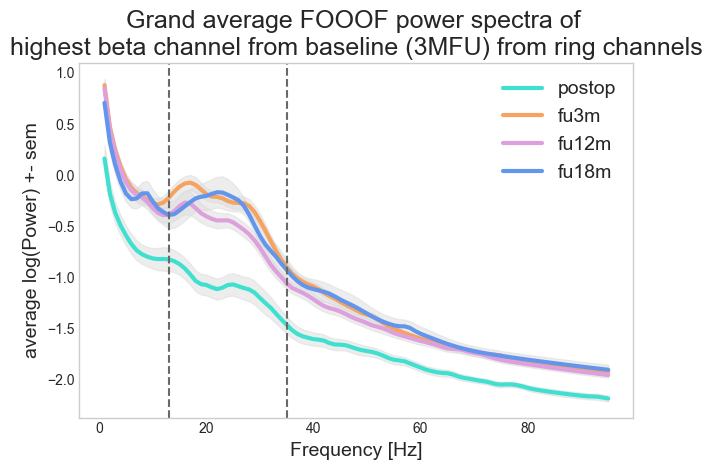

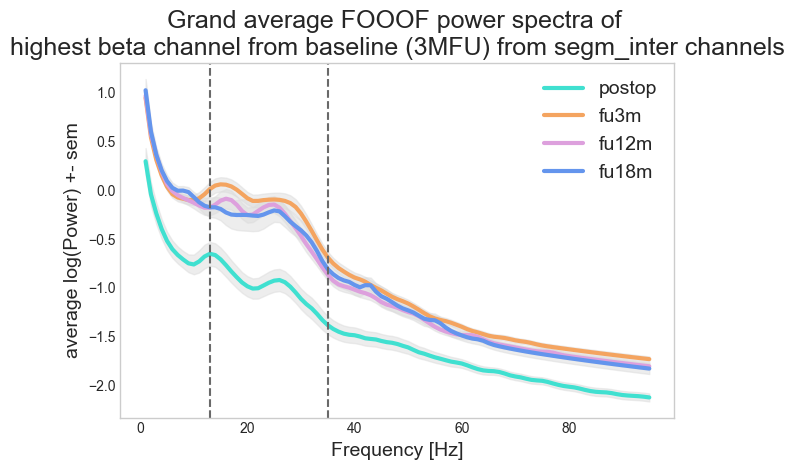

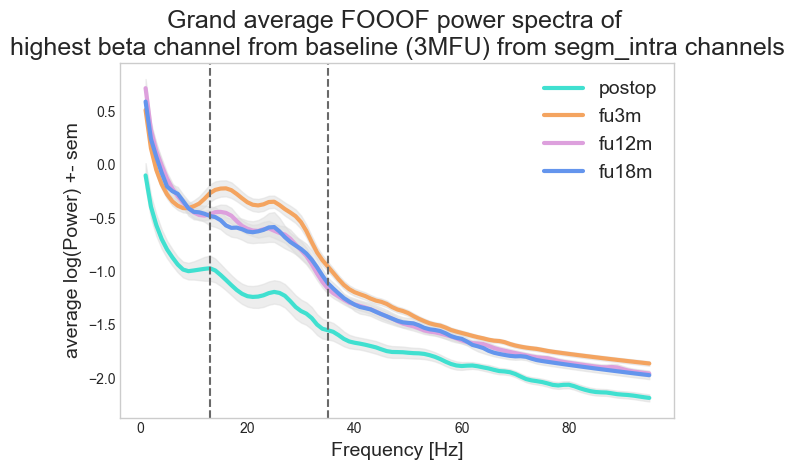

In [51]:
grand_av = cluster_perm.grand_average_power_spectra_fooof_highest_beta(
    std_or_sem="sem",
    spectrum_to_plot="periodic_plus_aperiodic",
    highest_beta_session="highest_fu3m"
)

In [32]:
grand_av

,session,channel_group,frequencies,power_spectrum_grand_average,standard_deviation,sem,sample_size
postop_ring,postop,ring,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 0.517622 1 0.227285 2 0.177450 3...,0 2.478877 1 1.033612 2 0.749612 3...,0 0.495775 1 0.206722 2 0.149922 3...,26
fu3m_ring,fu3m,ring,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 2.157685e-01 1 2.412920e-01 2 2....,0 5.096047e-01 1 6.058845e-01 2 6....,0 8.160206e-02 1 9.701917e-02 2 1....,40
fu12m_ring,fu12m,ring,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 1.638146e-01 1 2.331659e-01 2 3....,0 3.603680e-01 1 5.231531e-01 2 7....,0 7.514192e-02 1 1.090850e-01 2 1....,24
fu18m_ring,fu18m,ring,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 6.030170e-02 1 1.193659e-01 2 1....,0 1.581300e-01 1 3.367600e-01 2 3....,0 5.271000e-02 1 1.122533e-01 2 1....,10
postop_segm_inter,postop,segm_inter,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 0.330396 1 0.421703 2 0.371980 3...,0 1.375972 1 1.845677 2 1.554826 3...,0 0.275194 1 0.369135 2 0.310965 3...,26
fu3m_segm_inter,fu3m,segm_inter,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 9.186725e-02 1 1.071921e-01 2 1....,0 3.608948e-01 1 5.235085e-01 2 8....,0 5.778941e-02 1 8.382845e-02 2 1....,40
fu12m_segm_inter,fu12m,segm_inter,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 3.339046e-01 1 5.680525e-01 2 7....,0 6.829313e-01 1 1.378815e+00 2 2....,0 1.424010e-01 1 2.875028e-01 2 4....,24
fu18m_segm_inter,fu18m,segm_inter,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 2.449664e-01 1 1.535707e-01 2 1....,0 2.326896e-01 1 1.522117e-01 2 1....,0 7.756322e-02 1 5.073722e-02 2 4....,10
postop_segm_intra,postop,segm_intra,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 0.593483 1 0.557470 2 0.350136 3...,0 2.914597 1 2.727131 2 1.675613 3...,0 0.582919 1 0.545426 2 0.335123 3...,26
fu3m_segm_intra,fu3m,segm_intra,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0 6.790296e-03 1 1.525850e-02 2 3....,0 1.692795e-02 1 4.847636e-02 2 1....,0 2.710641e-03 1 7.762430e-03 2 2....,40


In [16]:
highest_postop_beta_chan = cluster_perm.highest_beta_channels_fooof(
    fooof_spectrum="periodic_spectrum",
    highest_beta_session="highest_postop"
)

In [18]:
stn_list = list(highest_postop_beta_chan.subject_hemisphere.unique())
stn_list

['024_Right',
 '024_Left',
 '025_Right',
 '025_Left',
 '026_Right',
 '026_Left',
 '028_Right',
 '028_Left',
 '029_Right',
 '029_Left',
 '030_Right',
 '030_Left',
 '031_Right',
 '031_Left',
 '032_Right',
 '032_Left',
 '038_Right',
 '038_Left',
 '060_Right',
 '060_Left']

In [33]:
average_fooof_spectra = power_spectra_plots.grand_average_FOOOF_spectra(
    std_or_sem="sem",
    spectrum_to_plot="periodic_flat",
    highest_beta_chans_only="yes"
    )

AttributeError: module 'src.bssu.utils.loadResults' has no attribute 'load_fooof_highest_beta_channels'

In [35]:
fooof_group_result = loadResults.load_group_fooof_result()
fooof_group_result.head()

,subject_hemisphere,session,bipolar_channel,fooof_error,fooof_r_sq,fooof_exponent,fooof_offset,fooof_power_spectrum,periodic_plus_aperiodic_power_log,fooof_periodic_flat,fooof_number_peaks,alpha_peak_CF_power_bandWidth,low_beta_peak_CF_power_bandWidth,high_beta_peak_CF_power_bandWidth,beta_peak_CF_power_bandWidth,gamma_peak_CF_power_bandWidth
0,017_Right,fu3m,03,0.067918,0.984748,1.604428,1.193436,"[0.1656846022, 0.1649261502, 0.2233027659, 0.3...","[1.1980212704, 0.724187351, 0.462702893, 0.301...","[0.0045849611, 0.0137320191, 0.0347733216, 0.0...",4,"[8.0361303964, 0.2920797276, 4.8819935441]","[None, None, None]","[28.9598253488, 0.59803925, 7.9884764194]","[28.9598253488, 0.59803925, 7.9884764194]","[None, None, None]"
1,017_Right,fu3m,13,0.065586,0.981937,1.434853,0.962182,"[0.0002512699, 0.000170312, 0.0001713231, 0.00...","[0.9621936876, 0.5302699055, 0.277622341, 0.09...","[1.19052e-05, 2.18158e-05, 3.92643e-05, 6.9409...",6,"[None, None, None]","[13.6525290415, 0.2751629151, 3.0043817008]","[29.104897124, 0.9469996839, 2.8278507762]","[29.104897124, 0.9469996839, 2.8278507762]","[None, None, None]"
2,017_Right,fu3m,02,0.103924,0.967577,1.543910,1.189600,"[0.109167965, 0.1121989401, 0.1548671509, 0.22...","[1.192653192, 0.7339231886, 0.476045302, 0.310...","[0.0030531773, 0.0090862584, 0.023077348, 0.05...",2,"[8.3809412096, 0.2263361467, 5.0237175086]","[None, None, None]","[29.0972672605, 0.961058298, 9.263451838]","[29.0972672605, 0.961058298, 9.263451838]","[None, None, None]"
3,017_Right,fu3m,12,0.075776,0.975321,1.304337,0.703128,"[0.0, 0.0, 0.0, 1e-10, 2e-10, 7e-10, 1.8e-09, ...","[0.7031279558, 0.3104833186, 0.0808009297, -0....","[0.0, 0.0, 0.0, 0.0, 2e-10, 6e-10, 2e-09, 6.7e...",5,"[None, None, None]","[None, None, None]","[29.4862293179, 1.095809808, 5.0314064061]","[29.4862293179, 1.095809808, 5.0314064061]","[63.6509137649, 0.2746917941, 2.0]"
4,017_Right,fu3m,01,0.064701,0.983808,1.540660,1.072680,"[8.3557e-06, 0.0002934975, 0.006412857, 0.0684...","[1.0726801321, 0.6089264437, 0.3388765881, 0.1...","[3.07e-07, 3.13674e-05, 0.0012781983, 0.020770...",6,"[None, None, None]","[None, None, None]","[33.221116688, 0.4390133666, 2.0]","[33.221116688, 0.4390133666, 2.0]","[63.7733341823, 0.1903054916, 10.5563791318]"


In [92]:
# transform all arrays with 95 values into a new dataframe with 95 rows = 1 row for each position
df_transposed = pd.DataFrame(fooof_group_result["fooof_power_spectrum"].tolist())

# Calculate the standard deviation for each position 
std_dev = df_transposed.apply(lambda x: stats.sem(x), axis=0)
std_dev

0     0.038744
1     0.039727
2     0.042447
3     0.024533
4     0.025436
        ...   
90    0.000018
91    0.000014
92    0.000012
93    0.000009
94    0.000006
Length: 95, dtype: float64

In [74]:
df_transposed

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,1.656846e-01,2.512700e-04,0.109168,0.000000e+00,8.355700e-06,0.000000e+00,0.000018,0.000007,3.497000e-07,2.706000e-07,...,0.004364,0.001308,0.000345,0.000006,1.467881e-02,0.000106,8.065718e-03,0.016668,4.991721e-04,2.400274e-03
1,1.649262e-01,1.703120e-04,0.112199,0.000000e+00,2.934974e-04,9.000000e-10,0.000015,0.000006,4.620000e-07,3.939000e-07,...,0.005739,0.001823,0.000510,0.000008,1.434694e-02,0.000214,9.045864e-03,0.016236,7.022528e-04,1.703745e-03
2,2.233028e-01,1.713231e-04,0.154867,0.000000e+00,6.412857e-03,1.810000e-08,0.000021,0.000008,8.088000e-07,7.763000e-07,...,0.009631,0.003252,0.001570,0.000015,1.789988e-02,0.001201,1.286811e-02,0.022113,1.329592e-03,1.786661e-03
3,3.157317e-01,2.004401e-04,0.222175,1.000000e-10,6.842155e-02,3.225000e-07,0.000156,0.000012,1.556200e-06,1.722100e-06,...,0.017005,0.006140,0.006039,0.000034,2.415278e-02,0.007483,1.959574e-02,0.033324,2.716337e-03,2.411286e-03
4,4.294795e-01,2.527159e-04,0.306231,2.000000e-10,3.597947e-01,4.504100e-06,0.002443,0.000018,3.103400e-06,8.479100e-06,...,0.029885,0.011580,0.020806,0.000132,3.353655e-02,0.032239,3.039160e-02,0.051718,5.590680e-03,4.286215e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2.263000e-07,2.300000e-09,0.000000,0.000000e+00,8.300000e-09,0.000000e+00,0.000000,0.000000,1.800000e-08,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,1.214306e-16,0.000000,3.500000e-09,0.000000,1.400000e-09,4.400000e-09
91,1.226000e-07,9.000000e-10,0.000000,0.000000e+00,3.000000e-09,0.000000e+00,0.000000,0.000000,8.800000e-09,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,4.163336e-17,0.000000,1.700000e-09,0.000000,6.000000e-10,1.800000e-09
92,6.520000e-08,3.000000e-10,0.000000,0.000000e+00,1.100000e-09,0.000000e+00,0.000000,0.000000,4.300000e-09,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,1.387779e-17,0.000000,8.000000e-10,0.000000,2.000000e-10,7.000000e-10
93,3.410000e-08,1.000000e-10,0.000000,0.000000e+00,4.000000e-10,0.000000e+00,0.000000,0.000000,2.000000e-09,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,6.938894e-18,0.000000,4.000000e-10,0.000000,1.000000e-10,3.000000e-10


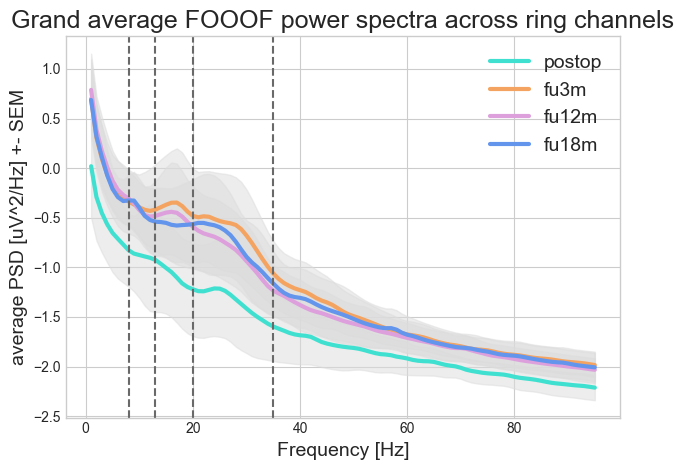

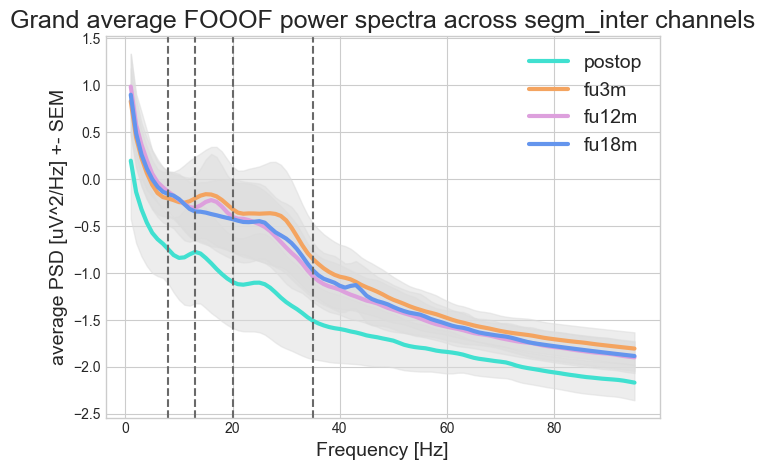

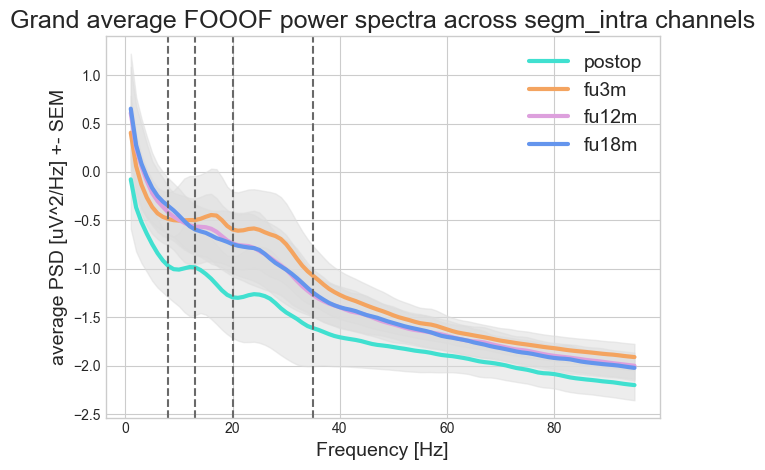

In [91]:
sessions = ["postop", "fu3m", "fu12m", "fu18m"]
channel_group = ["ring", "segm_inter", "segm_intra"]

############# PLOT THE GRAND AVERAGE POWER SPECTRUM PER SESSION #############

# Plot all power spectra in one figure, one color for each session
for group in channel_group:

    if group == "ring":
        channels = ['01', '12', '23']
    
    elif group == "segm_inter":
        channels = ["1A2A", "1B2B", "1C2C"]
    
    elif group == "segm_intra":
        channels = ['1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C']

    group_df = fooof_group_result.loc[fooof_group_result["bipolar_channel"].isin(channels)]

    # 4 colors used for the cycle of matplotlib 
    cycler_colors = cycler("color", ["turquoise", "sandybrown", "plum", "cornflowerblue"])
    plt.rc('axes', prop_cycle=cycler_colors)

    fig = plt.figure(layout="tight")

    average_spectra = {}

    for ses in sessions:

        session_df = group_df.loc[group_df.session==ses]

        frequencies = np.arange(1, 96) # 1-95 Hz, 1 Hz resolution

        # power_spectrum_session_grand_average = np.mean(session_df.fooof_power_spectrum.values)

        # CALCULATE STANDARD DEVIATION AND SEM
        # transform all arrays with 95 values into a new dataframe with 95 columns = 1 column for each position (1-95)
        df_transposed = pd.DataFrame(session_df["periodic_plus_aperiodic_power_log"].tolist())

        power_spectrum_session_grand_average = df_transposed.apply(lambda x: np.mean(x), axis=0)

        # Calculate the standard deviation for each position 
        standard_deviation_session = df_transposed.apply(lambda x: np.std(x), axis=0)
        # standard_deviation_session = np.std(session_df.fooof_power_spectrum.values)
        sem_session = df_transposed.apply(lambda x: stats.sem(x), axis=0)
        #sem_session = stats.sem(session_df.fooof_power_spectrum.values)

        # save and return 
        average_spectra[f"{ses}_{group}"] = [ses, group, frequencies, power_spectrum_session_grand_average, standard_deviation_session, sem_session,
                                        len(session_df.periodic_plus_aperiodic_power_log.values)]
        
        # Plot the grand average power spectrum per session
        plt.plot(frequencies, power_spectrum_session_grand_average, label=ses, linewidth=3)

        # plot the standard deviation as shaded grey area
        plt.fill_between(frequencies, 
                    power_spectrum_session_grand_average-standard_deviation_session,
                    power_spectrum_session_grand_average+standard_deviation_session,
                    color="gainsboro", alpha=0.5)


    plt.title(f"Grand average FOOOF power spectra across {group} channels", fontdict={"size": 18})
    plt.legend(loc= 'upper right', fontsize=14)

    # add lines for freq Bands
    plt.axvline(x=8, color='dimgrey', linestyle='--')
    plt.axvline(x=13, color='dimgrey', linestyle='--')
    plt.axvline(x=20, color='dimgrey', linestyle='--')
    plt.axvline(x=35, color='dimgrey', linestyle='--')

    plt.xlabel("Frequency [Hz]", fontdict={"size": 14})
    # plt.xlim(1, 95)

    plt.ylabel("average PSD [uV^2/Hz] +- SEM", fontdict={"size": 14})
    #plt.ylim(-0.05, 3)

    fig.tight_layout()
    



Plot average of only the channels with highest beta average per channel group,session and STN

In [80]:
# write highest beta channels FOOOF Dataframe

highest_beta_df = writeGroupDF.highest_beta_channels_fooof(
    fooof_spectrum="periodic_flat"
)

file:  highest_beta_channels_fooof_periodic_flat.pickle 
written in:  c:\Users\jebe12\Research\Longterm_beta_project\results


In [73]:
highest_beta_df = loadResults.load_fooof_highest_beta_channels(
    fooof_spectrum="periodic_spectrum"
)

In [74]:
highest_beta_df

,index,subject_hemisphere,session,bipolar_channel,fooof_error,fooof_r_sq,fooof_exponent,fooof_offset,fooof_power_spectrum,periodic_plus_aperiodic_power_log,fooof_periodic_flat,fooof_number_peaks,alpha_peak_CF_power_bandWidth,low_beta_peak_CF_power_bandWidth,high_beta_peak_CF_power_bandWidth,beta_peak_CF_power_bandWidth,gamma_peak_CF_power_bandWidth,beta_average,beta_rank
2,5,017_Right,fu3m,23,0.065806,0.981375,1.270456,0.586390,"[0.0, 9e-10, 1.81e-08, 3.225e-07, 4.5041e-06, ...","[0.5863896015, 0.2039441538, -0.0197720839, -0...","[0.0, 2e-10, 8.2e-09, 2.112e-07, 3.9175e-06, 5...",6,"[None, None, None]","[13.5482374907, 0.502386695, 3.5204739647]","[30.781507243, 1.0756834082, 5.0572150049]","[30.781507243, 1.0756834082, 5.0572150049]","[None, None, None]",0.203085,1.0
0,12,017_Right,fu3m,1A2A,0.075245,0.974186,1.432761,1.125251,"[0.0, 0.0, 0.0, 1e-10, 3e-10, 1.5e-09, 6.4e-09...","[1.1252509681, 0.6939470111, 0.4416503698, 0.2...","[0.0, 0.0, 0.0, 0.0, 1e-10, 6e-10, 3.4e-09, 1....",5,"[None, None, None]","[None, None, None]","[30.9240579785, 1.0263474649, 7.65470379]","[30.9240579785, 1.0263474649, 7.65470379]","[61.0327408069, 0.2358308194, 11.1902796715]",0.270982,1.0
5,11,017_Right,fu3m,2A2C,0.061880,0.981951,1.257017,0.588691,"[6.33e-08, 9.46e-08, 2.001e-07, 4.766e-07, 1.1...","[0.5886913749, 0.2102915915, -0.0110580389, -0...","[7.1e-09, 2.53e-08, 8.92e-08, 3.048e-07, 1.002...",6,"[None, None, None]","[18.9683024982, 0.2633963957, 2.0]","[28.3198990082, 0.9595968113, 8.8782860886]","[28.3198990082, 0.9595968113, 8.8782860886]","[None, None, None]",0.177882,1.0
2,20,017_Right,fu12m,23,0.066275,0.988890,1.666388,1.386621,"[3.07823e-05, 4.01951e-05, 7.86631e-05, 0.0001...","[1.3866220259, 0.8849910957, 0.5915612775, 0.3...","[5.489e-07, 2.2749e-06, 8.7498e-06, 3.12309e-0...",3,"[None, None, None]","[13.7643553382, 0.765145508, 3.1413368111]","[28.5437425103, 0.9197207902, 5.3777187276]","[28.5437425103, 0.9197207902, 5.3777187276]","[None, None, None]",0.590499,1.0
0,27,017_Right,fu12m,1A2A,0.056268,0.987753,1.550723,1.246667,"[0.016995994, 0.0095950285, 0.0083051429, 0.00...","[1.2470848335, 0.7805438056, 0.5079052275, 0.3...","[0.0004180758, 0.0006912456, 0.0011214678, 0.0...",5,"[None, None, None]","[None, None, None]","[28.0574589266, 0.4277901943, 14.5348877876]","[28.0574589266, 0.4277901943, 14.5348877876]","[62.9743940452, 0.190879677, 3.2328324318]",0.117865,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1182,060_Left,postop,1A2A,0.065863,0.976810,1.215772,0.280811,"[1.8719e-06, 1.6187e-06, 1.9802e-06, 3.3051e-0...","[0.2808115546, -0.0851719822, -0.2992580208, -...","[4.259e-07, 8.553e-07, 1.713e-06, 4.0563e-06, ...",6,"[None, None, None]","[17.8679993299, 0.3921833175, 4.7390501095]","[25.9779699484, 0.7537012589, 4.8044504042]","[25.9779699484, 0.7537012589, 4.8044504042]","[None, None, None]",0.074181,1.0
5,1181,060_Left,postop,2A2C,0.051513,0.988831,1.359188,0.481342,"[2.39e-08, 6.58e-08, 2.395e-07, 9.166e-07, 3.4...","[0.4813424162, 0.0721861726, -0.1671547703, -0...","[3.4e-09, 2.42e-08, 1.528e-07, 8.649e-07, 4.38...",6,"[None, None, None]","[19.2650739371, 0.3189014449, 6.031888156]","[26.0375065115, 0.6290650829, 4.4391095303]","[26.0375065115, 0.6290650829, 4.4391095303]","[None, None, None]",0.048238,1.0
0,1188,060_Left,fu3m,12,0.125133,0.957236,1.284402,0.718869,"[0.6306462044, 0.3613202512, 0.2960741021, 0.2...","[0.7682735924, 0.3997199732, 0.1966378187, 0.0...","[0.0494042709, 0.0674942537, 0.0905841076, 0.1...",2,"[None, None, None]","[19.0491682222, 0.9173769866, 15.0]","[None, None, None]","[19.0491682222, 0.9173769866, 15.0]","[None, None, None]",0.512405,1.0
0,1197,060_Left,fu3m,1A2A,0.070058,0.986411,1.382690,1.157929,"[0.0166683178, 0.016235723, 0.0221128645, 0.03...","[1.1584321769, 0.7429742344, 0.5012570911, 0.3...","[0.0005029159, 0.0012762027, 0.0030387201, 0.0...",6,"[None, None, None]","[15.8753807666, 0.7898104217, 7.840496186]","[28.4705156709, 0.

## 2. Plot grand average across STNs of a channel group (Ring, SegmInter, SegmIntra) 

figure:  grand_average_power_spectra_SegmIntra_normPsdToSum40to90Hz_band-pass.png 
written in:  c:\Users\jebe12\Research\Longterm_beta_project\figures


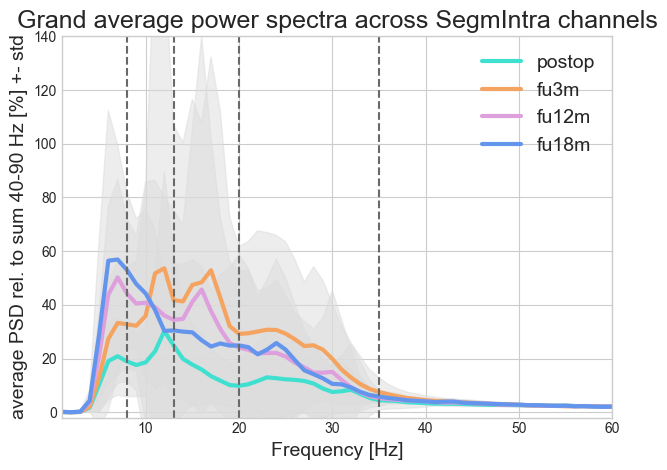

In [43]:
grand_average_power_spectra = power_spectra_plots.power_spectra_grand_average_per_session(
    incl_sub=["017", "019", "021", "024", "025", "026", "028", "029", "030", "031", "032", "033", "038", "041", "060"],
    channel_group="SegmIntra",
    signalFilter="band-pass",
    normalization="normPsdToSum40to90Hz"

)

In [ ]:
grand_average_power_spectra

In [ ]:
incl_sub=["017", "019", "021", "024", "025", "026", "028", "029", "030", "031", "032", "033", "038"]

sessions = ["postop", "fu3m", "fu12m", "fu18m"]
hemispheres = ["Right", "Left"]
channels = ['1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C']
signalFilter = "band-pass"

single_channels_dict = {}

for sub in incl_sub:

    for hem in hemispheres:

        # load all sessions and selected channel data per STN
        stn_power_spectra = mainAnalysis_class.MainClass(
                sub=sub,
                hemisphere=hem,
                filter=signalFilter,
                result="PowerSpectrum",
                incl_session=["postop", "fu3m", "fu12m", "fu18m"],
                pickChannels=channels,
                normalization=["rawPsd"],
                feature=["frequency", "time_sectors", 
                         "rawPsd", "SEM_rawPsd",
                         "normPsdToSum40to90Hz", "SEM_normPsdToSum40to90Hz"]
            )
        
        for ses in sessions:
            
            # check which sessions exist
            try:
                getattr(stn_power_spectra, ses)

            except AttributeError:
                continue

            for chan in channels: 
                    
                # get the power spectra and frequencies from each channel
                chan_data = getattr(stn_power_spectra, ses)
                chan_data = getattr(chan_data, f"BIP_{chan}")
                
                power_spectrum = np.array(chan_data.normPsdToSum40to90Hz.data)
                freqs = np.array(chan_data.frequency.data)

                # save all channels of an STN in a dict
                single_channels_dict[f"{sub}_{hem}_{ses}_{chan}"] = [sub, hem, ses, chan, power_spectrum, freqs]

# Dataframe with all single channels and their power_spectra + frequencies
single_channels_df = pd.DataFrame(single_channels_dict)
single_channels_df.rename(index={
    0: "subject",
    1: "hemisphere",
    2: "session",
    3: "bipolar_channel",
    4: "power_spectrum",
    5: "frequencies"
}, inplace=True)
single_channels_df = single_channels_df.transpose()

# join sub, hem columns together -> stn
single_channels_df["stn"] = single_channels_df[['subject', 'hemisphere']].agg('_'.join, axis=1)
single_channels_df.drop(columns=['subject', 'hemisphere'], inplace=True)

In [ ]:
single_channels_df.head()

In [ ]:
#session_df.power_spectrum.values

session_df.power_spectrum.count()

In [ ]:
# Plot all power spectra in one figure, one color for each session

# 4 colors used for the cycle of matplotlib 
cycler_colors = cycler("color", ["turquoise", "sandybrown", "plum", "cornflowerblue"])
plt.rc('axes', prop_cycle=cycler_colors)

fig = plt.figure(layout="tight")

average_spectra = {}
sample_size = {}

for idx, ses in enumerate(sessions):

    session_df = single_channels_df.loc[single_channels_df.session==ses]

    frequencies = session_df.frequencies.values[0]

    power_spectrum_session_grand_average = np.mean(session_df.power_spectrum.values)
    standard_deviation_session = np.std(session_df.power_spectrum.values)

    average_spectra[f"{ses}"] = [frequencies, power_spectrum_session_grand_average, standard_deviation_session]
    sample_size[f"{ses}"] = len(session_df.power_spectrum.values)


    plt.plot(frequencies, power_spectrum_session_grand_average, label=ses, linewidth=3)

    plt.fill_between(frequencies, 
                 power_spectrum_session_grand_average-standard_deviation_session,
                 power_spectrum_session_grand_average+standard_deviation_session,
                 color="gainsboro", alpha=0.5)


plt.title("Grand average power spectra across segmented-intra channels", fontdict={"size": 18})
plt.legend(loc= 'upper right', fontsize=14)

# add lines for freq Bands
plt.axvline(x=8, color='dimgrey', linestyle='--')
plt.axvline(x=13, color='dimgrey', linestyle='--')
plt.axvline(x=20, color='dimgrey', linestyle='--')
plt.axvline(x=35, color='dimgrey', linestyle='--')

plt.xlabel("Frequency [Hz]", fontdict={"size": 14})
plt.xlim(1, 60)
plt.ylabel("average PSD rel. to sum 40-90 Hz [%]", fontdict={"size": 14})
plt.ylim(-2, 80)

In [ ]:
# Plot all power spectra in one figure, one color for each session

# 4 colors used for the cycle of matplotlib 
cycler_colors = cycler("color", ["turquoise", "sandybrown", "plum", "cornflowerblue"])
plt.rc('axes', prop_cycle=cycler_colors)

fig = plt.figure(layout="tight")

average_spectra = {}

for idx, ses in enumerate(sessions):

    session_df = single_channels_df.loc[single_channels_df.session==ses]

    frequencies = session_df.frequencies.values[0]

    # plot each single channel power spectrum in light grey
    for s, spectrum in enumerate(list(session_df.power_spectrum.values)):

        plt.plot(frequencies, spectrum, color="lightgray")

    power_spectrum_session_grand_average = np.mean(session_df.power_spectrum.values)
    standard_deviation_session = np.std(session_df.power_spectrum.values)

    average_spectra[f"{ses}"] = [frequencies, power_spectrum_session_grand_average, standard_deviation_session]

# plot the grand average in color on top of the grey single channels
for session in sessions:
        
    plt.plot(average_spectra[f"{session}"][0], 
             average_spectra[f"{session}"][1], label=session, )
    #plt.fill_between(frequencies, 
                #  power_spectrum_session_grand_average-standard_deviation_session,
                #  power_spectrum_session_grand_average+standard_deviation_session,
                #  color="lightgray", alpha=0.5)


        
   


plt.title("Grand average Power spectrum across segmented intra channels", fontdict={"size": 18})
plt.legend(loc= 'upper right', edgecolor="black", fontsize=14)

# add lines for freq Bands
plt.axvline(x=8, color='black', linestyle='--')
plt.axvline(x=13, color='black', linestyle='--')
plt.axvline(x=20, color='black', linestyle='--')
plt.axvline(x=35, color='black', linestyle='--')

plt.xlabel("Frequency [Hz]", fontdict={"size": 14})
plt.xlim(1, 95)
plt.ylabel("grand average PSD to sum 40-90 Hz[%]", fontdict={"size": 14})

## 3. Calculate PSD averages of beta, high beta and low beta + plot Power Spectra from single STNs

In [ ]:
# plot Spectrograms if only one session is available
FF_psd = FFpsd.spectrogram_Psd_onlyONEsession(
    incl_sub = "037", 
    incl_session = ["fu3m"],
    incl_condition = ["m0s0"],
    pickChannels=['03', '13', '02', '12', '01', '23',
                  '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C',
                  '1A2A', '1B2B', '1C2C'],
    hemisphere="Left",
    filter = "band-pass"
)

## 4. Plot FOOOF spectra seperately per channel at different timepoints

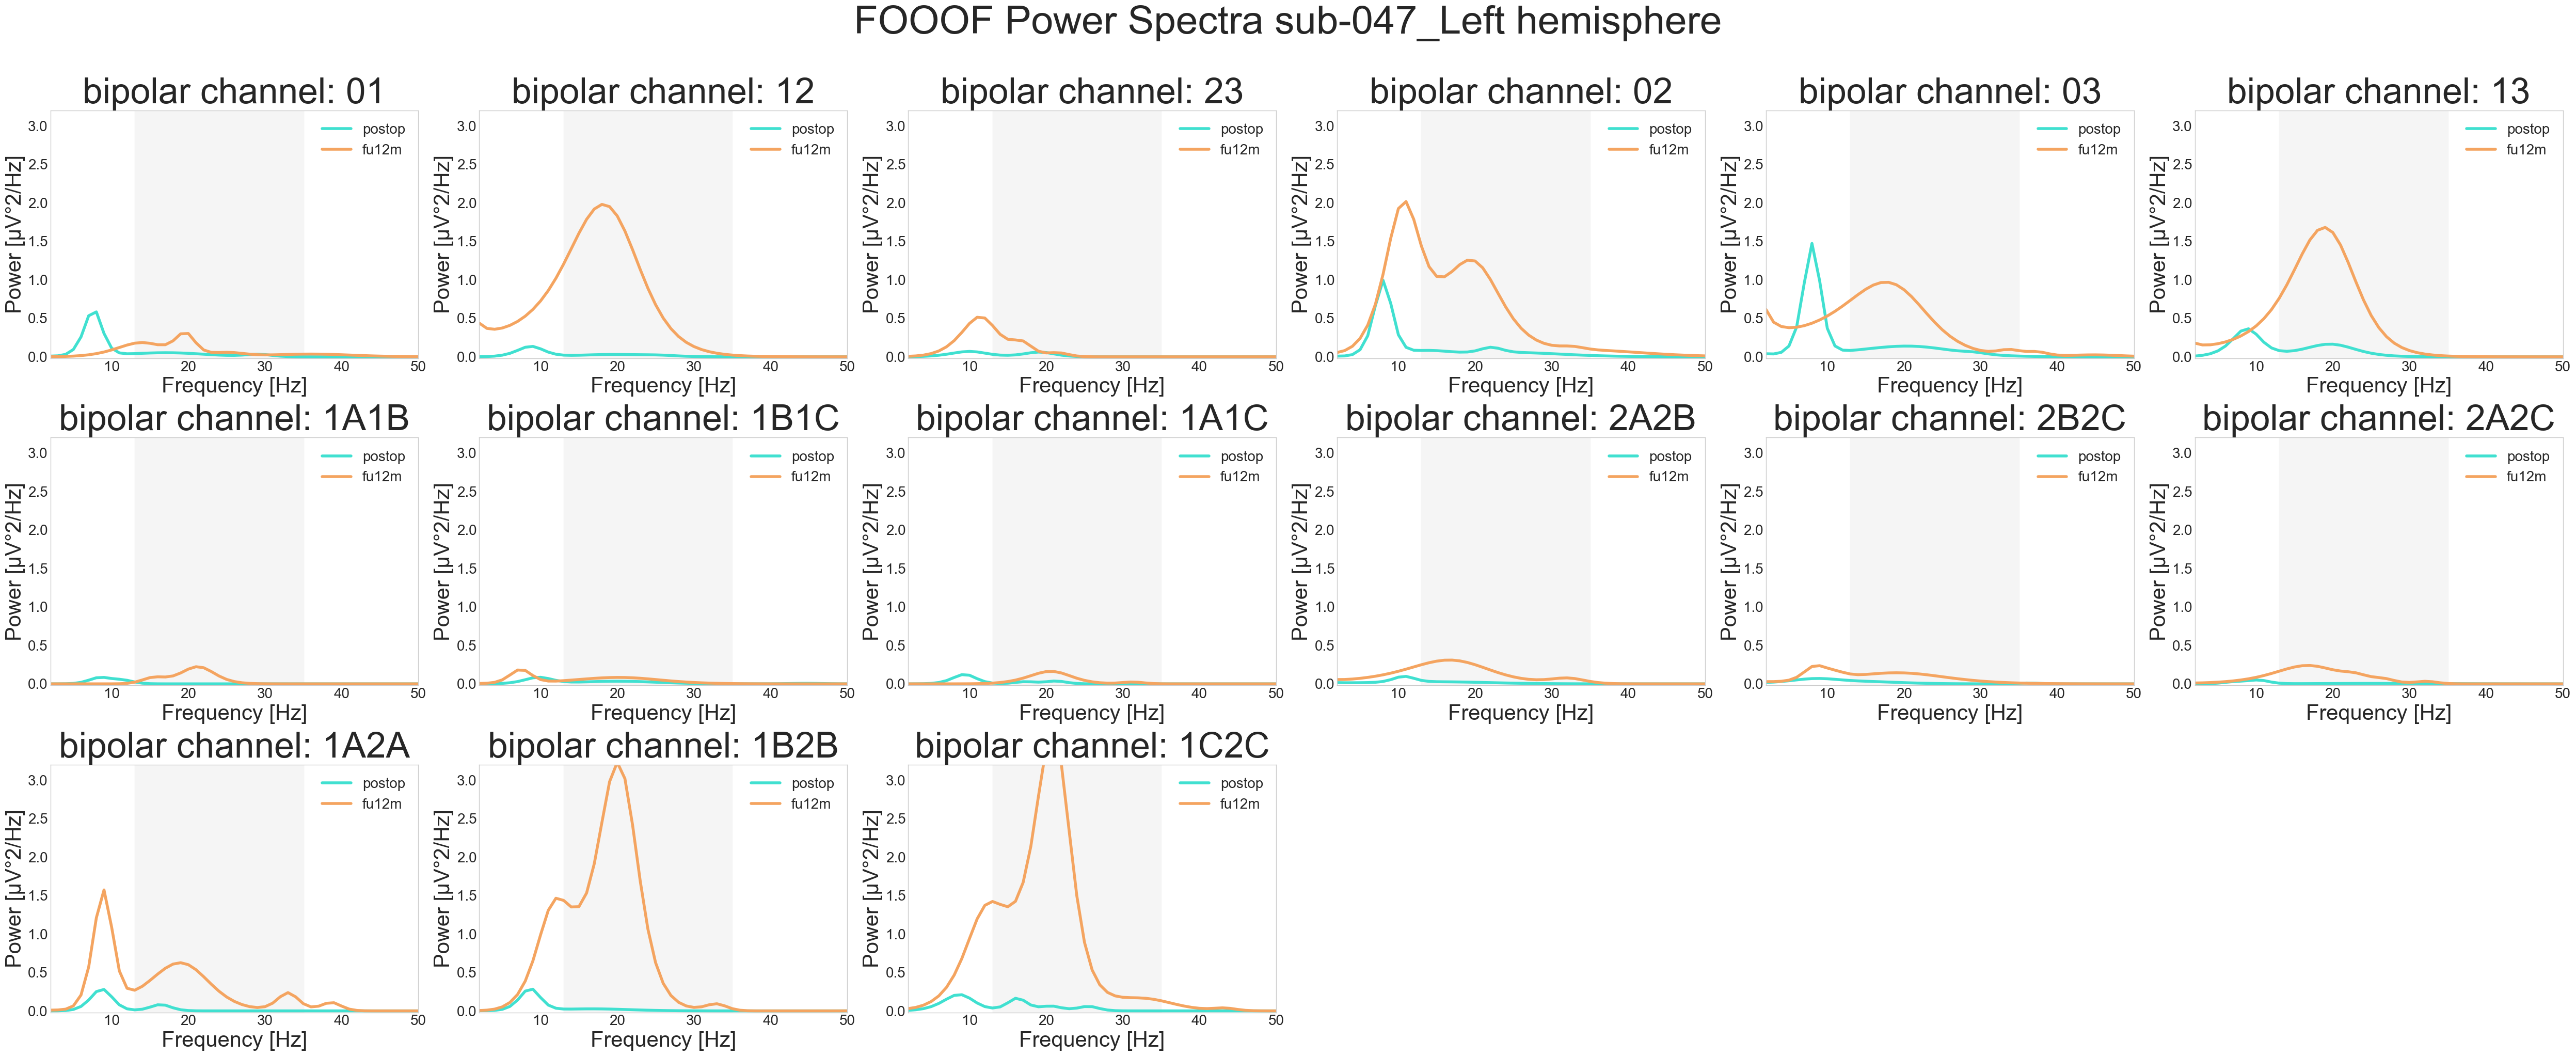

In [5]:
fooof_spectra_per_channel = power_spectra_plots.FOOOF_spectra_per_channel(
    incl_sub="047_Left",
    fooof_version="v2"
)

In [6]:
incl_sub = ["017", "019", "021", "024", "025", "026", "028", "029", "030", 
            "031", "032", "033", "036", "038", "040", "041", "045", "047", 
            "048", "049", "050", "052", "055", "059", "060", "061", "062", "063", "065", "066"]

hemispheres = ["Right", "Left"]

for sub in incl_sub:
    for hem in hemispheres:
        sub_hem = f"{sub}_{hem}"
        fooof_spectra_per_channel = power_spectra_plots.FOOOF_spectra_per_channel(
        incl_sub=sub_hem,
        fooof_version="v2")

## 4. Plot channels seperately per STN - longitudinal plot of single channels

In [ ]:
PowerSpectra_perChannels = power_spectra_plots.PowerSpectra_perChannel(
    sub="031",
    hemisphere="Left",
    incl_session=["postop", "fu3m"],
    signalFilter="band-pass",
    normalization=["rawPsd", "normPsdToTotalSum", "normPsdToSum1_100Hz", "normPsdToSum40_90Hz"]

)

In [ ]:
data = mainAnalysis_class.MainClass(
    sub="029",
    hemisphere = "Left",
    filter = "band-pass",
    result = "PowerSpectrum",
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    pickChannels = ['03', '13', '02', '12', '01', '23', 
                    '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C', 
                    '1A2A', '1B2B', '1C2C'],
    normalization = ["rawPsd", "normPsdToTotalSum", "normPsdToSum40_90Hz"],
    freqBands= None,
    feature = ["frequency", "rawPsd", "SEM_rawPsd", "normPsdToTotalSum", "SEM_normPsdToTotalSum",
               "normPsdToSum40to90Hz", "SEM_normPsdToSum40to90Hz"],
    
)

Create three groups: Ring, SegmInter, SegmIntra

for each group plot the PSD average of each channel over time (x=session, y=PSD average), average PSD over channels within a group (+- standard deviation)
each group is a column, plot one channel per Row, within one subplot: Power spectrum of one channel at different timepoints

In [ ]:
data.postop.BIP_02.Result_DF

Plot each channel in a seperate subplot with all timepoints

visually compare the development over time of each single channel

In [ ]:
timepoints = ["postop", "fu3m", "fu12m", "fu18m"]

Ring = ['BIP_03', 'BIP_13', 'BIP_02', 'BIP_12', 'BIP_01', 'BIP_23']
SegmIntra = ['BIP_1A1B', 'BIP_1B1C', 'BIP_1A1C', 'BIP_2A2B', 'BIP_2B2C', 'BIP_2A2C']
SegmInter = ['BIP_1A2A', 'BIP_1B2B', 'BIP_1C2C']

groupChannels = ["Ring", "SegmIntra", "SegmInter"]

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize= (50, 20), layout="tight")

# Create a list of 15 colors and add it to the cycle of matplotlib 
cycler_colors = cycler("color", ["black", "blue", "lime", "darkred"])
plt.rc('axes', prop_cycle=cycler_colors)


for g, group in enumerate(groupChannels):

    # loop through Ring, SegmIntra, SegmInter each will create a row (rows n=3)
    # eval(group) gives takes from the string "Ring" the variable Ring, so we can loop through the list Ring 
    for c, chan in enumerate(eval(group)):

        # subplot layout: one row for each group, max. 6 columns, if 6 BIP channels, index from left to right 1-16
        if group == "Ring":

            plt.subplot(3, 6, c+1, label=chan)
        
        elif group == "SegmIntra":
            plt.subplot(3, 6, c+7, label=chan,)
        
        elif group == "SegmInter":
            plt.subplot(3, 6, c+13, label=chan)

        else: 
            print("group must be Ring, SegmIntra or SegmInter")


        for tp in timepoints:
            PowerSpectrum = getattr(data, tp)
            PowerSpectrum = getattr(PowerSpectrum, chan)

            f = PowerSpectrum.frequency.data
            psd = np.array(PowerSpectrum.normPsdToTotalSum.data)
            sem = np.array(PowerSpectrum.SEM_normPsdToTotalSum.data)

            plt.title(f"{chan}", fontdict={"size": 50})
            plt.plot(f, psd, label = f"{tp}")
            plt.fill_between(f, psd-sem, psd+sem, color="lightgray", alpha=0.5)

            # add lines for freq Bands
            plt.axvline(x=8, color='black', linestyle='--')
            plt.axvline(x=13, color='black', linestyle='--')
            plt.axvline(x=20, color='black', linestyle='--')
            plt.axvline(x=35, color='black', linestyle='--')

            plt.xlabel("Frequency [Hz]", fontdict={"size": 30})
            # plt.ylim(0, 20) # for rel PSD to sum 1-100Hz
            # plt.ylim(0, 4) # for absolute PSD
            # plt.ylim(0, 150) # for rel PSD to sum 40-90Hz
            plt.ylim(0, 17) # for rel PSD to sum 40-90Hz
            plt.xlim(2, 50)
            plt.ylabel("PSD to sum 40-90 Hz[%]+-SEM", fontdict={"size": 30})
            plt.xticks(fontsize= 20), plt.yticks(fontsize= 20)
            plt.legend(loc= 'upper right', edgecolor="black", fontsize=20)

fig.suptitle("Power Spectra sub-029, Right hemisphere, band-pass filtered, relative Psd to sum 40-90Hz", fontsize=55, y=1.02)
fig.subplots_adjust(wspace=40, hspace=60)

#plt.tight_layout(pad=10, w_pad=10, h_pad=10)

plt.show()

Plot FOOOF spectra

## 5. Plot FOOOF channels per group (Ring, SegmInter, SegmIntra) of single STNs

In [ ]:
PowerSpectra = power_spectra_plots.PowerSpectra_perChannelGroup(
    sub="029",
    hemisphere="Left",
    incl_session=["postop", "fu3m", "fu12m", "fu18m"],
    signalFilter="band-pass",
    normalization=["rawPsd", "normPsdToTotalSum", "normPsdToSum1_100Hz", "normPsdToSum40_90Hz"]
)

In [ ]:
sessions = ["postop", "fu3m", "fu12m", "fu18m"]
groupChannels = ["Ring", "SegmIntra", "SegmInter"]

Ring = ['BIP_03', 'BIP_13', 'BIP_02', 'BIP_12', 'BIP_01', 'BIP_23']
SegmIntra = ['BIP_1A1B', 'BIP_1B1C', 'BIP_1A1C', 'BIP_2A2B', 'BIP_2B2C', 'BIP_2A2C']
SegmInter = ['BIP_1A2A', 'BIP_1B2B', 'BIP_1C2C']

fig = plt.figure(figsize= (30, 30), layout="tight")

for g, group in enumerate(groupChannels): # 0,1,2
      
    for s, ses in enumerate(sessions): # 0,1,2,3
    #for g, group in enumerate(groupChannels):

        if ses == "postop":
            plt.subplot(4,3,s+g+1, label=f"{group}_{ses}") # e.g. 0+0+1, 0+1+1, 0+2+1 = row1
        
        if ses == "fu3m":
            plt.subplot(4,3,s+g+3, label=f"{group}_{ses}") # e.g. 1+0+3, 1+1+3, 1+2+3 = row1
        
        if ses == "fu12m":
            plt.subplot(4,3,s+g+5, label=f"{group}_{ses}") # e.g. 2+0+5, 2+1+5, 2+2+5 = row1
        
        if ses == "fu18m":
            plt.subplot(4,3,s+g+7, label=f"{group}_{ses}") # e.g. 3+0+7, 3+1+7, 3+2+7 = row1

        # for each group, get all channels
        for c, chan in enumerate(eval(group)):
            # get f, psd and sem from data
            PowerSpectrum = getattr(data, ses)
            PowerSpectrum = getattr(PowerSpectrum, chan)

            f = PowerSpectrum.frequency.data
            psd = np.array(PowerSpectrum.rawPsd.data)
            sem = np.array(PowerSpectrum.SEM_rawPsd.data)

            # plot each Power spectrum for each channel in the same group_ses subplot
            plt.title(f"{group}_{ses}", fontdict={"size": 40})
            plt.plot(f, psd, label = f"{chan}")
            plt.fill_between(f, psd-sem, psd+sem, color="lightgray", alpha=0.5)

            # add lines for freq Bands
            plt.axvline(x=8, color='black', linestyle='--')
            plt.axvline(x=13, color='black', linestyle='--')
            plt.axvline(x=20, color='black', linestyle='--')
            plt.axvline(x=35, color='black', linestyle='--')

            plt.xlabel("Frequency [Hz]", fontdict={"size": 30})
            plt.xlim(2, 50)
            plt.ylabel("absolute PSD [uV^2/Hz+-SEM]", fontdict={"size": 30})
            plt.xticks(fontsize= 20), plt.yticks(fontsize= 20)
            plt.legend(loc= 'upper right', edgecolor="black", fontsize=20)


# Title of each plot per normalization variant
fig.suptitle("Power Spectra", fontsize=55, y=1.02)

# adjust Layout
fig.subplots_adjust(wspace=40, hspace=60)
# plt.tight_layout(pad=10, w_pad=10, h_pad=10)

plt.show()

Plot FOOOF spectra per channel group 

In [7]:
fooof_group_result = loadResults.load_fooof_beta_ranks(
        fooof_spectrum="periodic_spectrum",
        fooof_version="v2",
        all_or_one_chan="beta_ranks_all"
        )
fooof_group_result.head()

,index,subject_hemisphere,session,bipolar_channel,fooof_error,fooof_r_sq,fooof_exponent,fooof_offset,fooof_power_spectrum,periodic_plus_aperiodic_power_log,fooof_periodic_flat,fooof_number_peaks,alpha_peak_CF_power_bandWidth,low_beta_peak_CF_power_bandWidth,high_beta_peak_CF_power_bandWidth,beta_peak_CF_power_bandWidth,gamma_peak_CF_power_bandWidth,beta_average,beta_rank
0,3,017_Right,fu3m,12,0.075776,0.975321,1.304337,0.703128,"[0.0, 0.0, 0.0, 1e-10, 2e-10, 7e-10, 1.8e-09, ...","[0.7031279558, 0.3104833186, 0.0808009297, -0....","[0.0, 0.0, 0.0, 0.0, 2e-10, 6e-10, 2e-09, 6.7e...",5,"[None, None, None]","[None, None, None]","[29.4862293179, 1.095809808, 5.0314064061]","[29.4862293179, 1.095809808, 5.0314064061]","[63.6509137649, 0.2746917941, 2.0]",0.202904,2.0
1,4,017_Right,fu3m,01,0.064701,0.983808,1.540660,1.072680,"[8.3557e-06, 0.0002934975, 0.006412857, 0.0684...","[1.0726801321, 0.6089264437, 0.3388765881, 0.1...","[3.07e-07, 3.13674e-05, 0.0012781983, 0.020770...",6,"[None, None, None]","[None, None, None]","[33.221116688, 0.4390133666, 2.0]","[33.221116688, 0.4390133666, 2.0]","[63.7733341823, 0.1903054916, 10.5563791318]",0.032465,3.0
2,5,017_Right,fu3m,23,0.065806,0.981375,1.270456,0.586390,"[0.0, 9e-10, 1.81e-08, 3.225e-07, 4.5041e-06, ...","[0.5863896016, 0.2039441538, -0.0197720838, -0...","[0.0, 2e-10, 8.2e-09, 2.112e-07, 3.9175e-06, 5...",6,"[None, None, None]","[13.548237489, 0.5023866959, 3.5204739565]","[30.7815072507, 1.0756834085, 5.0572149919]","[30.7815072507, 1.0756834085, 5.0572149919]","[None, None, None]",0.203085,1.0
0,12,017_Right,fu3m,1A2A,0.075245,0.974186,1.432761,1.125251,"[0.0, 0.0, 0.0, 1e-10, 3e-10, 1.5e-09, 6.4e-09...","[1.1252509701, 0.6939470127, 0.4416503712, 0.2...","[0.0, 0.0, 0.0, 0.0, 1e-10, 6e-10, 3.4e-09, 1....",5,"[None, None, None]","[None, None, None]","[30.9240579815, 1.0263474645, 7.6547037983]","[30.9240579815, 1.0263474645, 7.6547037983]","[61.0327408328, 0.2358308207, 11.1902795197]",0.270982,1.0
1,13,017_Right,fu3m,1B2B,0.066098,0.975025,1.140977,0.528676,"[0.0272617763, 0.0190132646, 0.0179378651, 0.0...","[0.5321666932, 0.1905650625, -0.0077053177, -0...","[0.0034907276, 0.0053573729, 0.0080030543, 0.0...",6,"[None, None, None]","[17.3561037974, 0.1399782169, 12.1680970911]","[31.2598267953, 0.9824960343, 3.8570494366]","[31.2598267953, 0.9824960343, 3.8570494366]","[None, None, None]",0.161970,2.0


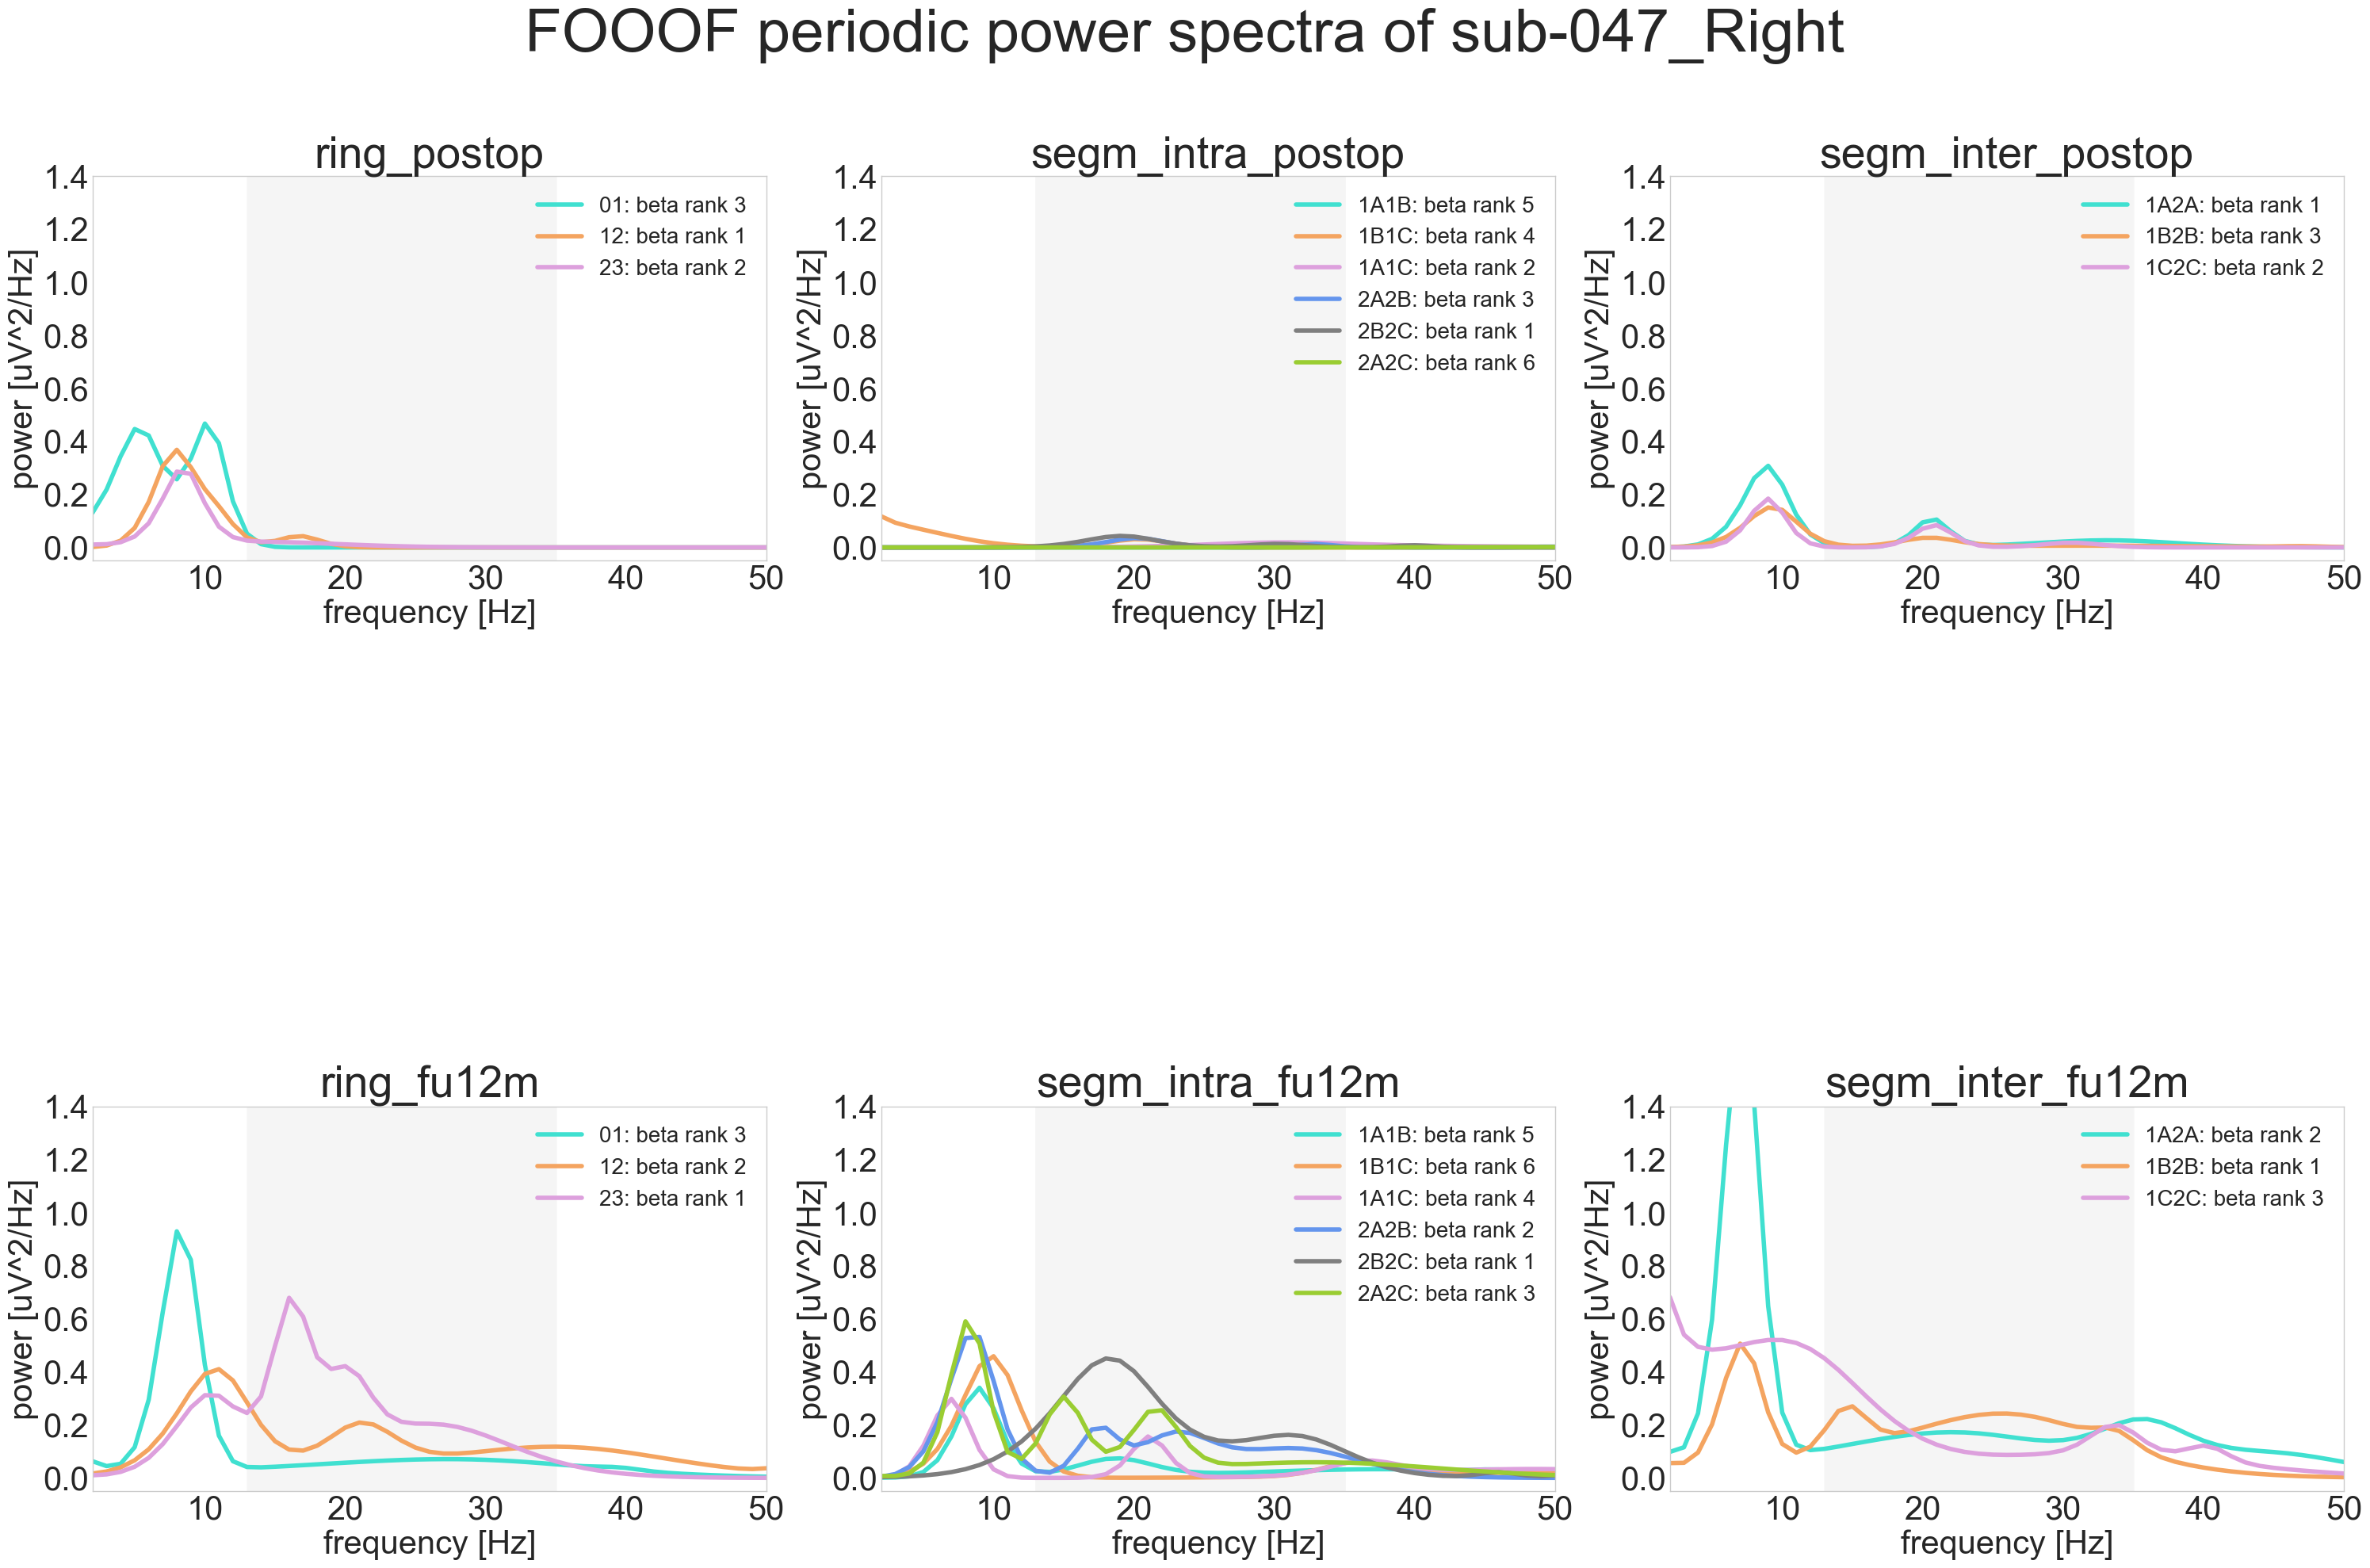

In [7]:
plot_fooof_spectra_per_channel_group = power_spectra_plots.fooof_spectra_per_channel_group(
    fooof_spectrum="periodic_spectrum",
    fooof_version="v2",
    specific_sub_hem= ["047_Right"]
)

In [8]:
incl_sub = ["017", "019", "021", "024", "025", "026", "028", "029", "030", 
            "031", "032", "033", "036", "038", "040", "041", "045", "047", 
            "048", "049", "050", "052", "055", "059", "060", "061", "062", "063", "065", "066"]

hemispheres = ["Right", "Left"]

for sub in incl_sub:
    for hem in hemispheres:
        sub_hem = f"{sub}_{hem}"
        plot_fooof_spectra_per_channel_group = power_spectra_plots.fooof_spectra_per_channel_group(
            fooof_spectrum="periodic_spectrum",
            fooof_version="v2",
            specific_sub_hem= [sub_hem]
        )

In [96]:
sessions = ["postop", "fu3m", "fu12m", "fu18m"]
group_channels = ["ring", "segm_intra", "segm_inter"]

ring = ['01', '12', '23']
segm_inter = ["1A2A", "1B2B", "1C2C"]
segm_intra = ['1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C']

stn_list = list(fooof_group_result.subject_hemisphere.unique())
#stn_list = ["041_Right", "045_Right", "059_Right", "060_Right", "061_Right", "062_Right", "063_Right", 
#            "041_Left", "045_Left", "059_Left", "060_Left", "061_Left", "062_Left", "063_Left"]


# one figure for each subject
for stn in stn_list:

    sub_hem = stn.split("_")
    sub = sub_hem[0]

    subject_figures_path = find_folders.get_local_path(folder="figures", sub=sub)

    stn_df = fooof_group_result.loc[fooof_group_result.subject_hemisphere == stn]

    # 5 colors used for the cycle of matplotlib 
    cycler_colors = cycler("color", ["turquoise", "sandybrown", "plum", "cornflowerblue", "tab:grey", "yellowgreen"])
    plt.rc('axes', prop_cycle=cycler_colors)


    fig = plt.figure(figsize= (30, 30), layout="tight")

    for g, group in enumerate(group_channels): # 0,1,2
        
        for s, ses in enumerate(sessions): # 0,1,2,3
        
            # check if session exists
            if ses not in stn_df.session.values:
                continue

            elif ses == "postop":
                plt.subplot(4,3,s+g+1, label=f"{group}_{ses}") # e.g. 0+0+1, 0+1+1, 0+2+1 = row1
            
            elif ses == "fu3m":
                plt.subplot(4,3,s+g+3, label=f"{group}_{ses}") # e.g. 1+0+3, 1+1+3, 1+2+3 = row1
            
            elif ses == "fu12m":
                plt.subplot(4,3,s+g+5, label=f"{group}_{ses}") # e.g. 2+0+5, 2+1+5, 2+2+5 = row1
            
            elif ses == "fu18m":
                plt.subplot(4,3,s+g+7, label=f"{group}_{ses}") # e.g. 3+0+7, 3+1+7, 3+2+7 = row1

            session_df = stn_df.loc[stn_df.session == ses]

            # for each group, get all channels
            for c, chan in enumerate(eval(group)):
                # get f, psd and sem from data
                chan_ses_df = session_df.loc[session_df.bipolar_channel == chan]

                beta_rank = chan_ses_df.beta_rank.values[0].astype(int)
                power_spectrum = chan_ses_df.fooof_power_spectrum.values[0]
                frequencies = np.arange(1, 96) # 1-95 Hz, 1 Hz resolution

                # plot each Power spectrum for each channel in the same group_ses subplot
                plt.title(f"{group}_{ses}", fontdict={"size": 40})
                plt.plot(frequencies, power_spectrum, label = f"{chan}: beta rank {beta_rank}", linewidth=4)

                # add lines for freq Bands
                #plt.axvline(x=8, color='grey', linestyle='--')
                # plt.axvline(x=13, color='grey', linestyle='--')
                # #plt.axvline(x=20, color='grey', linestyle='--')
                # plt.axvline(x=35, color='grey', linestyle='--')
                x1 = 13
                x2 = 35
                plt.axvspan(x1, x2, color="whitesmoke")

                plt.xlabel("frequency [Hz]", fontdict={"size": 30})
                plt.xlim(2, 50)
                plt.ylim(-0.05, 3.5)
                plt.ylabel("power [uV^2/Hz+-SEM]", fontdict={"size": 30})
                plt.xticks(fontsize= 20), plt.yticks(fontsize= 20)
                plt.legend(loc= 'upper right', edgecolor="black", fontsize=20)
                plt.grid(False)


    # Title of each plot per normalization variant
    fig.suptitle(f"FOOOF periodic power spectra of sub-{stn}", fontsize=55, y=1.02)

    # adjust Layout
    fig.subplots_adjust(wspace=40, hspace=60)
    # plt.tight_layout(pad=10, w_pad=10, h_pad=10)

    # fig.savefig(subject_figures_path + f"\\sub_{stn}_fooof_power_spectra_per_channelgroup.svg", 
    #                 bbox_inches = "tight", format="svg")
    
    fig.savefig(os.path.join(subject_figures_path, f"sub_{stn}_fooof_power_spectra_per_channelgroup.png"), 
                    bbox_inches = "tight")



In [ ]:
sessions = ["postop", "fu3m", "fu12m", "fu18m"]
channel_group = ["ring", "segm_inter", "segm_intra"]

ring = ['01', '12', '23', '02', '03', '13']
segm_inter = ["1A2A", "1B2B", "1C2C"]
segm_intra = ['1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C']

# stn_list = list(fooof_group_result.subject_hemisphere.unique())
stn_list = ["029_Right"]

# one figure for each subject
for stn in stn_list:

    sub_hem = stn.split("_")
    sub = sub_hem[0]

    subject_figures_path = find_folders.get_local_path(folder="figures", sub=sub)

    stn_df = fooof_group_result.loc[fooof_group_result.subject_hemisphere == stn]

    # 5 colors used for the cycle of matplotlib 
    cycler_colors = cycler("color", ["black", "blue", "lime", "red", "yellow"])
    plt.rc('axes', prop_cycle=cycler_colors)

    # one figure for each normalization variant
    fig = plt.figure(figsize= (50, 20), layout="tight")

    # loop through Ring, SegmIntra, SegmInter each will create a row (rows n=3)
    for group in channel_group:

        # eval(group)  takes from the string "Ring" the variable Ring, so we can loop through the list Ring 
        for c, chan in enumerate(eval(group)):

            # subplot layout: one row for each group, max. 6 columns, if 6 BIP channels, index from left to right 1-16
            if group == "ring":
                plt.subplot(3, 6, c+1, label=chan) # indeces 1-6 (first row)
            
            elif group == "segm_intra":
                plt.subplot(3, 6, c+7, label=chan,) # indeces 7-12 (second row)
            
            elif group == "segm_inter":
                plt.subplot(3, 6, c+13, label=chan) # indices 13-15 (third row) - only 3 Channels in SegmInter

            else: 
                print("group must be Ring, SegmIntra or SegmInter")
            

            for ses in sessions:

                # check if session exists
                if ses not in stn_df.session.values:
                    continue

                # get the correct row of the stn dataframe
                chan_ses_df = stn_df.loc[stn_df.bipolar_channel == chan]
                chan_ses_df = chan_ses_df.loc[chan_ses_df.session == ses]

                power_spectrum = chan_ses_df.fooof_power_spectrum.values[0]
                frequencies = np.arange(1, 96) # 1-95 Hz, 1 Hz resolution

                # plot each Power spectrum for each channel seperately, different lines and colors for each session
                plt.title(f"bipolar channel: {chan}", fontdict={"size": 50})
                
                plt.plot(frequencies, power_spectrum, label = f"{ses}")

                # add lines for freq Bands
                plt.axvline(x=8, color='black', linestyle='--')
                plt.axvline(x=13, color='black', linestyle='--')
                plt.axvline(x=20, color='black', linestyle='--')
                plt.axvline(x=35, color='black', linestyle='--')

                plt.xlabel("Frequency [Hz]", fontdict={"size": 30})
                plt.xlim(2, 50)
                plt.ylabel("Power [µV°2/Hz]", fontdict={"size": 30})
                plt.ylim(-0.02, 2.5)
                plt.xticks(fontsize= 20), plt.yticks(fontsize= 20)
                plt.legend(loc= 'upper right', edgecolor="black", fontsize=20)

    # Title of each plot per normalization variant
    fig.suptitle(f"FOOOF Power Spectra sub-{stn} hemisphere", fontsize=55, y=1.02)

    # adjust Layout
    fig.subplots_adjust(wspace=40, hspace=60)
    # plt.tight_layout(pad=10, w_pad=10, h_pad=10)

    fig.savefig(subject_figures_path + f"\\sub_{stn}_fooof_power_spectra_per_channel.png", 
                    bbox_inches = "tight")



## 6. Normalized recordings to Postop or 3MFU 

Use automatized method for plotting normalized PSD to Postop and 3MFU

TODO: statistical analysis -> Friedman or ANOVA test of paired groups?

new files:  normalizedToPostop_rawPsd_beta.pickle 
and: normalizedToFu3m_rawPsd_beta.pickle 
written in:  c:\Users\jebe12\Research\Longterm_beta_project\results 
new figure: relativeTo_Fu3m_rawPsd_beta_barplot_plotPerBipolarChannel.png 
written in:  c:\Users\jebe12\Research\Longterm_beta_project\figures


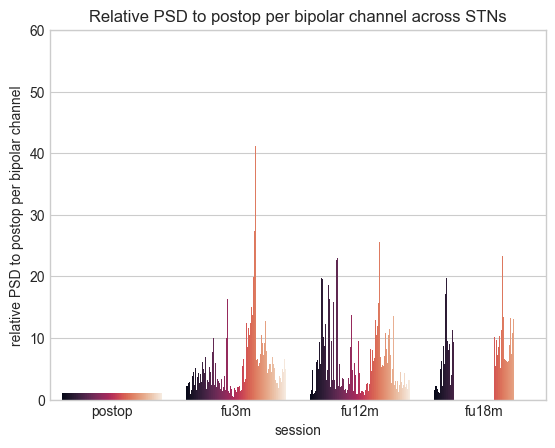

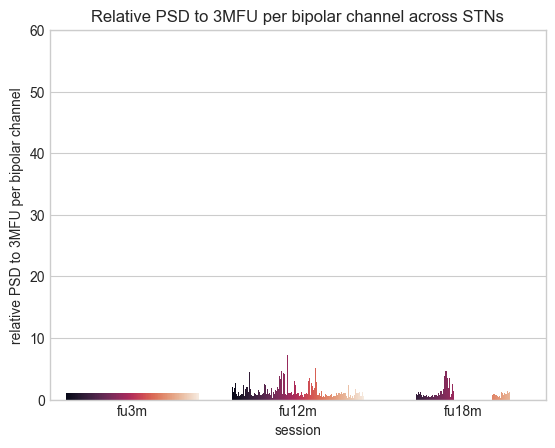

In [18]:
plotNormalizedPSD_perChannel = BIP_perChannel.BIP_channelNormalizedToSession(
    incl_sub=["017", "019", "024", "025", "026", "029", "030"],
    normalization="rawPsd",
    freqBand="beta",
    plot="plotPerBipolarChannel"
)

In [ ]:
incl_sub =  ["017", "019", "024", "025", "026", "029", "030"]
hemispheres = ["Right", "Left"]
normalization = "rawPsd"
freqBand = "beta"
sessions = ["fu3m", "fu12m", "fu18m"]
BIP_channels = ['BIP_03', 'BIP_13', 'BIP_02', 'BIP_12', 'BIP_01', 'BIP_23', 
                'BIP_1A1B', 'BIP_1B1C', 'BIP_1A1C', 'BIP_2A2B', 'BIP_2B2C', 'BIP_2A2C',
                'BIP_1A2A', 'BIP_1B2B', 'BIP_1C2C']


normalized_psd_Dict = {}

for sub in incl_sub:
    for hem in hemispheres:

        sub_hem_data = mainAnalysis_class.MainClass(
            sub=sub,
            hemisphere=hem,
            filter="band-pass",
            result="PSDaverageFrequencyBands",
            incl_session=["postop", "fu3m", "fu12m", "fu18m"],
            pickChannels=['03', '13', '02', '12', '01', '23', 
                            '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C', 
                            '1A2A', '1B2B', '1C2C'],
            normalization=[normalization],
            freqBands=["beta", "lowBeta", "highBeta"],
            feature=["averagedPSD"]
        )

        # for every channel get PSD for each session and normalize to postop
        for c, chan in enumerate(BIP_channels):

            # check if postop exists 
            try:
                getattr(sub_hem_data, "postop")
            
            except AttributeError:
                continue

            # first get postop PSD
            postop_PSD = getattr(sub_hem_data.postop, chan)
            postop_PSD = getattr(postop_PSD, normalization)
            postop_PSD = getattr(postop_PSD, freqBand)
            postop_PSD = postop_PSD.averagedPSD.data

            normalized_postop = postop_PSD/postop_PSD

            # store in dictionary
            normalized_psd_Dict[f"{sub}_{hem}_{chan}_postop"] = [sub, hem, "postop", chan, normalized_postop]

            # normalize all other session PSD values to postop PSD
            for ses in sessions:

                # check if session exists
                try: 
                    getattr(sub_hem_data, ses)
                
                except AttributeError:
                    continue

                session_PSD = getattr(sub_hem_data, ses)
                session_PSD = getattr(session_PSD, chan)
                session_PSD = getattr(session_PSD, normalization)
                session_PSD = getattr(session_PSD, freqBand)
                session_PSD = session_PSD.averagedPSD.data

                normalized_session_PSD = session_PSD/postop_PSD
                
                # store in dictionary
                normalized_psd_Dict[f"{sub}_{hem}_{chan}_{ses}"] = [sub, hem, ses, chan, normalized_session_PSD]

In [ ]:
normalized_psd_Dataframe = pd.DataFrame(normalized_psd_Dict)
normalized_psd_Dataframe.rename(index={0: "subject", 1: "hemisphere", 2: "session", 3: "bipolarChannel", 4: "beta_Psd_normalized_to_postop"}, inplace=True)
normalized_psd_Dataframe = normalized_psd_Dataframe.transpose()
normalized_psd_Dataframe["subject_hemisphere"] = normalized_psd_Dataframe[["subject", "hemisphere"]].agg('_'.join, axis=1)
normalized_psd_Dataframe["subject_hemisphere_BIPchannel"] = normalized_psd_Dataframe[["subject", "hemisphere", "bipolarChannel"]].agg('_'.join, axis=1)
normalized_psd_Dataframe.drop(["subject", "hemisphere", "bipolarChannel"], axis=1, inplace=True)
normalized_psd_Dataframe

In [ ]:
fig = plt.figure()

ax = sns.lineplot(data=normalized_psd_Dataframe, x="session", y="beta_Psd_normalized_to_postop")
plt.title("Beta PSD relative to postop per bipolar channel across STNs")
plt.ylabel("Beta PSD rel. to postop per bipolar channel")

In [ ]:
fig = plt.figure()

ax = sns.barplot(data=normalized_psd_Dataframe, x="session", y="beta_Psd_normalized_to_postop", palette="Set2")
plt.title("Relative PSD to postop per bipolar channel across STNs")
plt.ylabel("relative PSD to postop per bipolar channel")
plt.ylim(0, 60)

figures_path = find_folders.get_local_path(folder="GroupFigures")
fig.savefig(figures_path + f"\\relativeTo_Postop_rawPSD_beta_barplot.png", bbox_inches="tight")

In [ ]:
fig = plt.figure()

ax = sns.barplot(data=normalized_psd_Dataframe, x="session", y="beta_Psd_normalized_to_postop", hue="subject_hemisphere", palette="viridis")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.8))
plt.title("Relative PSD to postop per bipolar channel across STNs")
plt.ylabel("relative PSD to postop per bipolar channel")
plt.ylim(0, 60)

figures_path = find_folders.get_local_path(folder="GroupFigures")
fig.savefig(figures_path + f"\\relativeTo_Postop_rawPSD_beta_barplot_perSTN.png", bbox_inches="tight")

In [ ]:
fig = plt.figure()

ax = sns.barplot(data=normalized_psd_Dataframe, x="session", y="beta_Psd_normalized_to_postop", hue="subject_hemisphere_BIPchannel", palette="rocket")
# plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.8))
ax.get_legend().remove()
plt.title("Relative PSD to postop per bipolar channel across STNs")
plt.ylabel("relative PSD to postop per bipolar channel")
plt.ylim(0, 60)

figures_path = find_folders.get_local_path(folder="GroupFigures")
fig.savefig(figures_path + f"\\relativeTo_Postop_rawPSD_beta_barplot_perSTN_BIPchannel.png", bbox_inches="tight")

normalized to 3MFU

In [ ]:
incl_sub =  ["017", "019", "024", "025", "026", "029", "030"]
hemispheres = ["Right", "Left"]
normalization = "rawPsd"
freqBand = "beta"
sessions = ["fu12m", "fu18m"]
BIP_channels = ['BIP_03', 'BIP_13', 'BIP_02', 'BIP_12', 'BIP_01', 'BIP_23', 
                'BIP_1A1B', 'BIP_1B1C', 'BIP_1A1C', 'BIP_2A2B', 'BIP_2B2C', 'BIP_2A2C',
                'BIP_1A2A', 'BIP_1B2B', 'BIP_1C2C']


normalizedToFu3m_psd_Dict = {}

for sub in incl_sub:
    for hem in hemispheres:

        sub_hem_data = mainAnalysis_class.MainClass(
            sub=sub,
            hemisphere=hem,
            filter="band-pass",
            result="PSDaverageFrequencyBands",
            incl_session=["fu3m", "fu12m", "fu18m"],
            pickChannels=['03', '13', '02', '12', '01', '23', 
                            '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C', 
                            '1A2A', '1B2B', '1C2C'],
            normalization=[normalization],
            freqBands=["beta", "lowBeta", "highBeta"],
            feature=["averagedPSD"]
        )

        # for every channel get PSD for each session and normalize to postop
        for c, chan in enumerate(BIP_channels):

            # check if postop exists 
            try:
                getattr(sub_hem_data, "fu3m")
            
            except AttributeError:
                continue

            # first get postop PSD
            fu3m_PSD = getattr(sub_hem_data.fu3m, chan)
            fu3m_PSD = getattr(fu3m_PSD, normalization)
            fu3m_PSD = getattr(fu3m_PSD, freqBand)
            fu3m_PSD = fu3m_PSD.averagedPSD.data

            normalized_fu3m = fu3m_PSD/fu3m_PSD

            # store in dictionary
            normalizedToFu3m_psd_Dict[f"{sub}_{hem}_{chan}_fu3m"] = [sub, hem, "fu3m", chan, normalized_postop]

            # normalize all other session PSD values to postop PSD
            for ses in sessions:

                # check if session exists
                try: 
                    getattr(sub_hem_data, ses)
                
                except AttributeError:
                    continue

                session_PSD = getattr(sub_hem_data, ses)
                session_PSD = getattr(session_PSD, chan)
                session_PSD = getattr(session_PSD, normalization)
                session_PSD = getattr(session_PSD, freqBand)
                session_PSD = session_PSD.averagedPSD.data

                normalized_session_PSD = session_PSD/fu3m_PSD
                
                # store in dictionary
                normalizedToFu3m_psd_Dict[f"{sub}_{hem}_{chan}_{ses}"] = [sub, hem, ses, chan, normalized_session_PSD]

In [ ]:
normalizedToFu3m_psd_Dataframe = pd.DataFrame(normalizedToFu3m_psd_Dict)
normalizedToFu3m_psd_Dataframe.rename(index={0: "subject", 1: "hemisphere", 2: "session", 3: "bipolarChannel", 4: "beta_Psd_normalized_to_fu3m"}, inplace=True)
normalizedToFu3m_psd_Dataframe = normalizedToFu3m_psd_Dataframe.transpose()
normalizedToFu3m_psd_Dataframe["subject_hemisphere"] = normalizedToFu3m_psd_Dataframe[["subject", "hemisphere"]].agg('_'.join, axis=1)
normalizedToFu3m_psd_Dataframe["subject_hemisphere_BIPchannel"] = normalizedToFu3m_psd_Dataframe[["subject", "hemisphere", "bipolarChannel"]].agg('_'.join, axis=1)
normalizedToFu3m_psd_Dataframe.drop(["subject", "hemisphere", "bipolarChannel"], axis=1, inplace=True)
normalizedToFu3m_psd_Dataframe

In [ ]:
fig = plt.figure()

ax = sns.lineplot(data=normalizedToFu3m_psd_Dataframe, x="session", y="beta_Psd_normalized_to_fu3m")

In [ ]:
fig = plt.figure()

ax = sns.barplot(data=normalizedToFu3m_psd_Dataframe, x="session", y="beta_Psd_normalized_to_fu3m", palette="Set2")
plt.title("Relative PSD to 3MFU per bipolar channel across STNs")
plt.ylabel("relative PSD to 3MFU per bipolar channel")
plt.ylim(0, 7)

figures_path = find_folders.get_local_path(folder="GroupFigures")
fig.savefig(figures_path + f"\\relativeTo_Fu3m_rawPSD_beta_barplot.png", bbox_inches="tight")

In [ ]:
fig = plt.figure()

ax = sns.barplot(data=normalizedToFu3m_psd_Dataframe, x="session", y="beta_Psd_normalized_to_fu3m", hue="subject_hemisphere", palette="viridis")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.8))
plt.title("Relative PSD to 3MFU per bipolar channel across STNs")
plt.ylabel("relative PSD to 3MFU per bipolar channel")
plt.ylim(0, 7)

figures_path = find_folders.get_local_path(folder="GroupFigures")
fig.savefig(figures_path + f"\\relativeTo_Fu3m_rawPSD_beta_barplot_perSTN.png", bbox_inches="tight")

In [ ]:
fig = plt.figure()

ax = sns.barplot(data=normalizedToFu3m_psd_Dataframe, x="session", y="beta_Psd_normalized_to_fu3m", hue="subject_hemisphere_BIPchannel", palette="rocket")
# plt.legend(loc="upper right", bbox_to_anchor=(1.3, 0.8))
ax.get_legend().remove()

plt.title("Relative PSD to 3MFU per bipolar channel across STNs")
plt.ylabel("relative PSD to 3MFU per bipolar channel")
plt.ylim(0, 7)

figures_path = find_folders.get_local_path(folder="GroupFigures")
fig.savefig(figures_path + f"\\relativeTo_Fu3m_rawPSD_beta_barplot_perSTN_BIPchannel.png", bbox_inches="tight")

## 7. Plot the PSD average within beta/high beta/low beta

- plot seperately in 3 groups: Ring (6 channels), SegmIntra (6 channels), SegmInter (3 channels)
- get the average of all subject hemisphere per timepoint
- plot mean of all subject_hemispheres +- standard deviation (distribution)

In [20]:
sns.color_palette("viridis", n_colors=25)

[(0.277941, 0.056324, 0.381191),
 (0.283091, 0.110553, 0.431554),
 (0.280868, 0.160771, 0.472899),
 (0.271828, 0.209303, 0.504434),
 (0.257322, 0.25613, 0.526563),
 (0.239346, 0.300855, 0.540844),
 (0.221989, 0.339161, 0.548752),
 (0.203063, 0.379716, 0.553925),
 (0.185556, 0.41857, 0.556753),
 (0.169646, 0.456262, 0.55803),
 (0.154815, 0.493313, 0.55784),
 (0.140536, 0.530132, 0.555659),
 (0.127568, 0.566949, 0.550556),
 (0.120092, 0.600104, 0.54253),
 (0.123444, 0.636809, 0.528763),
 (0.146616, 0.67305, 0.508936),
 (0.19109, 0.708366, 0.482284),
 (0.252899, 0.742211, 0.448284),
 (0.327796, 0.77398, 0.40664),
 (0.404001, 0.800275, 0.362552),
 (0.496615, 0.826376, 0.306377),
 (0.595839, 0.848717, 0.243329),
 (0.699415, 0.867117, 0.175971),
 (0.804182, 0.882046, 0.114965),
 (0.906311, 0.894855, 0.098125)]

In [ ]:
# use the functions
# PsdAverage_RingSegmGroups includes ALL RING CHANNELS
# PsdAverage_specificRingSegmGroups only includes SPECIFIC RING CHANNELS 01,12,13

BIP_function = BIP_channelGroups.PsdAverage_RingSegmGroups(
    incl_sub=["017", "019", "021","024", "025", "026", "028", "029", "030", "031", "032", "033", "038"] ,
    signalFilter="band-pass",
    normalization="normPsdToSum40_90Hz",
    freqBands=["alpha", "beta", "highBeta", "lowBeta"]
)

# plot as lineplot

# BIP_function = BIP_channelGroups.PsdAverage_specificRingSegmGroups_lineplot(
#     incl_sub=["024", "025", "026", "029", "030", "033"] ,
#     signalFilter="band-pass",
#     normalization="normPsdToSum40_90Hz",
#     freqBands=["alpha", "beta", "highBeta", "lowBeta"]
# )


In [ ]:
BIP_function["Ring_DF"]['017_Right_fu3m_alpha']

In [ ]:
# load the data of one subject

data = mainAnalysis_class.MainClass(
    sub="017",
    hemisphere = "Right",
    filter = "band-pass",
    result = "PeakParameters",
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    pickChannels = ['03', '13', '02', '12', '01', '23', 
                    '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C', 
                    '1A2A', '1B2B', '1C2C'],
    normalization = ["rawPsd"],
    freqBands = ["beta", "highBeta", "lowBeta"],
    feature= ["PEAK_frequency", "PEAK_amplitude", "PEAK_5HzAverage"]
)
    

In [ ]:
# loop through the data of all subjects

subjects = ["017", "019", "024", "025", "026", "029", "030"]
hemispheres = ["Right", "Left"]
sessions = ["postop", "fu3m", "fu12m", "fu18m"]

data = {}
Ring_DF = {}
SegmIntra_DF = {}
SegmInter_DF = {}

for sub in subjects:
    for hem in hemispheres:

        # load the data from each subject hemisphere
        data[f"{sub}_{hem}"] = mainAnalysis_class.MainClass(
            sub=sub,
            hemisphere = hem,
            filter = "band-pass",
            result = "PeakParameters",
            incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
            pickChannels = ['03', '13', '02', '12', '01', '23', 
                            '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C', 
                            '1A2A', '1B2B', '1C2C'],
            normalization = ["rawPsd"],
            freqBands = ["beta", "highBeta", "lowBeta"],
            feature= ["PEAK_frequency", "PEAK_amplitude", "PEAK_5HzAverage"]
        )
        
        # for each timepoint seperately, get the Dataframes of the correct normalization and frequency band
        for ses in sessions:

            # get the Dataframe
            if ses == "postop":
                # Error check: check if session exists as an attribute of one subject_hemisphere object
                try: 
                    data[f"{sub}_{hem}"].postop
                
                except AttributeError:
                    continue
                    
                session_DF = data[f"{sub}_{hem}"].postop.Result_DF # select for session
                norm_session_DF = session_DF[session_DF.absoluteOrRelativePSD == "rawPsd"] # select for absolute PSD instead of relative
                freqBand_norm_session_DF = norm_session_DF[norm_session_DF.frequencyBand == "beta"] # select  for beta frequency band
            
            # get the Dataframe
            if ses == "fu3m":
                # Error check: check if session exists as an attribute of one subject_hemisphere object
                try: 
                    data[f"{sub}_{hem}"].fu3m
                
                except AttributeError:
                    continue
                    
                session_DF = data[f"{sub}_{hem}"].fu3m.Result_DF # select for session
                norm_session_DF = session_DF[session_DF.absoluteOrRelativePSD == "rawPsd"] # select for absolute PSD instead of relative
                freqBand_norm_session_DF = norm_session_DF[norm_session_DF.frequencyBand == "beta"] # select  for beta frequency band
            
            # get the Dataframe
            if ses == "fu12m":
                # Error check: check if session exists as an attribute of one subject_hemisphere object
                try: 
                    data[f"{sub}_{hem}"].fu12m
                
                except AttributeError:
                    continue
                    
                session_DF = data[f"{sub}_{hem}"].fu12m.Result_DF # select for session
                norm_session_DF = session_DF[session_DF.absoluteOrRelativePSD == "rawPsd"] # select for absolute PSD instead of relative
                freqBand_norm_session_DF = norm_session_DF[norm_session_DF.frequencyBand == "beta"] # select  for beta frequency band
            
            # get the Dataframe
            if ses == "fu18m":
                # Error check: check if session exists as an attribute of one subject_hemisphere object
                try: 
                    data[f"{sub}_{hem}"].fu18m
                
                except AttributeError:
                    continue
                    
                session_DF = data[f"{sub}_{hem}"].fu18m.Result_DF # select for session
                norm_session_DF = session_DF[session_DF.absoluteOrRelativePSD == "rawPsd"] # select for absolute PSD instead of relative
                freqBand_norm_session_DF = norm_session_DF[norm_session_DF.frequencyBand == "beta"] # select  for beta frequency band


            # divide the Dataframe in 3 groups: Ring, SegmIntra, SegmInter
            Ring = ['03', '13', '02', '12', '01', '23']
            SegmIntra = ['1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C'] 
            SegmInter = ['1A2A', '1B2B', '1C2C']

            # Dataframe with all Ring Channels
            Ring_DF[f"{sub}_{hem}_{ses}"] = pd.DataFrame()
            for chan in Ring:
                channel_DF = freqBand_norm_session_DF[freqBand_norm_session_DF.bipolarChannel.str.contains(chan)]
                Ring_DF[f"{sub}_{hem}_{ses}"] = pd.concat([Ring_DF[f"{sub}_{hem}_{ses}"], channel_DF] )

            # Dataframe with all SegmIntra Channels
            SegmIntra_DF[f"{sub}_{hem}_{ses}"] = pd.DataFrame()
            for chan in SegmIntra:
                channel_DF = freqBand_norm_session_DF[freqBand_norm_session_DF.bipolarChannel.str.contains(chan)]
                SegmIntra_DF[f"{sub}_{hem}_{ses}"] = pd.concat([SegmIntra_DF[f"{sub}_{hem}_{ses}"], channel_DF])

            # Dataframe with all SegmInter Channels
            SegmInter_DF[f"{sub}_{hem}_{ses}"] = pd.DataFrame()
            for chan in SegmInter:
                channel_DF = freqBand_norm_session_DF[freqBand_norm_session_DF.bipolarChannel.str.contains(chan)]
                SegmInter_DF[f"{sub}_{hem}_{ses}"] = pd.concat([SegmInter_DF[f"{sub}_{hem}_{ses}"], channel_DF])
            

            

In [ ]:
Ring_DF["024_Right_postop"]

In [ ]:
# get the average of all channels of one sub_hem_session_channel group 
# e.g. average of all Ring channels (n=6) of sub-24, Right, postop

meanPSD_RingChannels = {}
meanPSD_SegmIntraChannels = {}
meanPSD_SegmInterChannels = {}

# list of all existing combinations, e.g. ["024_Right_postop", "024_Right_fu3m"]
sub_hem_ses_combinations = list(Ring_DF.keys())

# get the mean from column averagedPSD of each combination for Ring, SegmIntra, SegmInter
# also get Standard deviation for each sub_hem_ses ???
for combination in sub_hem_ses_combinations:

    # split the sub_hem_ses combinations into sub_hem (will be label of plot) and ses (will be x axis)
    combination_split = combination.split("_")
    subject_hemisphere = "".join([combination_split[0], "_", combination_split[1]])
    sess = combination_split[2]
    
    # for each group, calculate the mean over the averagedPSD column, add to dictionary together with subject_hemisphere and session 
    meanPSD_RingChannels[combination] = [Ring_DF[combination].PEAK_frequency.mean(), subject_hemisphere, sess]
    meanPSD_SegmIntraChannels[combination] = [SegmIntra_DF[combination].PEAK_frequency.mean(), subject_hemisphere, sess]
    meanPSD_SegmInterChannels[combination] = [SegmInter_DF[combination].PEAK_frequency.mean(), subject_hemisphere, sess]

In [ ]:
meanPSD_RingChannels["017_Left_fu12m"]

In [ ]:
# new Dataframes per group Ring, SegmIntra, SegmInter
Ring_DF_meanChannels = pd.DataFrame.from_dict(meanPSD_RingChannels, orient="index", columns=["PEAKfrequency_beta_ChannelsPerHemisphere", "subject_hemisphere", "session"]) # keys of the dictionary will be indeces
Ring_DF_meanChannels.session.replace("postop", "fu0m", inplace=True)

SegmIntra_DF_meanChannels = pd.DataFrame.from_dict(meanPSD_SegmIntraChannels, orient="index", columns=["PEAKfrequency_beta_ChannelsPerHemisphere", "subject_hemisphere", "session"]) # keys of the dictionary will be indeces
SegmIntra_DF_meanChannels.session.replace("postop", "fu0m", inplace=True)

SegmInter_DF_meanChannels = pd.DataFrame.from_dict(meanPSD_SegmInterChannels, orient="index", columns=["PEAKfrequency_beta_ChannelsPerHemisphere", "subject_hemisphere", "session"]) # keys of the dictionary will be indeces
SegmInter_DF_meanChannels.session.replace("postop", "fu0m", inplace=True)

In [ ]:
plt.figure()

ax = sns.boxplot(data=Ring_DF_meanChannels, x='session', y='PEAKfrequency_beta_ChannelsPerHemisphere', order=sessions, palette="Blues", width=0.8)
ax = sns.stripplot(x = "session",
    y = 'PEAKfrequency_beta_ChannelsPerHemisphere',
    hue = "subject_hemisphere",
    order=sessions,
    size=10,
    data = Ring_DF_meanChannels,
    )

pairs = list(combinations(sessions,2)) # list of pairs of combinations, e.g. "postop" vs "fu3m"

# to do a paired statistical test, number of values within each group must be equal!!! take out sub017, sub019, and session fu18m
# annotator = Annotator(ax, pairs, data=Ring_DF_meanChannels, x='session', y='PSDaverage_beta_ChannelsPerHemisphere')
# annotator.configure(test='t-test_paired', text_format='star')
# annotator.apply_and_annotate()

plt.title("Ring Channels")
plt.legend(loc= "upper right", bbox_to_anchor=(1.4, 1))
plt.tight_layout()

#plt.savefig(results_sub_folder + f"\\compareMonopolarPSDaverage_{freq_band}_{sub_hemisphere}_Wilcoxon.png")

In [ ]:
sessions = ["fu0m", "fu3m", "fu12m", "fu18m"]

# Create a list of 15 colors and add it to the cycle of matplotlib 
cycler_colors = cycler("color", ["blue", "navy", "deepskyblue", "purple", "green", "darkolivegreen", "magenta", "orange", "red", "darkred", "chocolate", "gold", "cyan",  "yellow", "lime"])
plt.rc('axes', prop_cycle=cycler_colors)
plt.figure(figsize=(5, 10), layout="tight")

channelGroup = ["Ring", "SegmIntra", "SegmInter"]
data_DF = {}

for g, group in enumerate(channelGroup):
    if group == "Ring":
        data_DF[group] = Ring_DF_meanChannels
        
    elif group == "SegmIntra":
        data_DF[group] = SegmIntra_DF_meanChannels
        

    elif group == "SegmInter":
        data_DF[group] = SegmInter_DF_meanChannels

    plt.subplot(3,1,g+1)
    #sns.lineplot(data=data_DF[group], x='session', y='PSDaverage_beta_ChannelsPerHemisphere', size_order=sessions)
    
    sns.boxplot(data=data_DF[group], 
                x='session', 
                y='PEAKfrequency_beta_ChannelsPerHemisphere', 
                order=sessions, 
                palette="Blues", 
                width=0.8,
                )
    # whis = whiskers are makers to define outliers
    sns.stripplot(x = "session",
        y = 'PEAKfrequency_beta_ChannelsPerHemisphere',
        hue = "subject_hemisphere",
        order=sessions,
        size=5,
        jitter=True,
        data = data_DF[group],
        )

    #pairs = list(combinations(sessions,2)) # list of pairs of combinations, e.g. "postop" vs "fu3m"

    # to do a paired statistical test, number of values within each group must be equal!!! take out sub017, sub019, and session fu18m
    # annotator = Annotator(ax, pairs, data=Ring_DF_meanChannels, x='session', y='PSDaverage_beta_ChannelsPerHemisphere')
    # annotator.configure(test='t-test_paired', text_format='star')
    # annotator.apply_and_annotate()

    plt.title(f"{group} Channels: PSD average in beta band")
    plt.ylabel("Peak Frequency")

    plt.legend(loc= "upper right", bbox_to_anchor=(1.4, 1))
    
    if group == "SegmIntra":
        plt.legend().remove()
    
    elif group == "SegmInter":
        plt.legend().remove()
        
        
    plt.tight_layout()

In [ ]:
# make 3 subplots with titles Ring, SegmIntra, SegmInter

# per subplot, get mean +- SD of meanPSD of all sub_hem_ses combinations
# plot e.g. Ring channels, PSD average of beta band averaged per hemisphere and session
# x axis = sessions (postop, fu3m, fu12m, fu18m)
# y axis = PSD average in beta band
# label = sub_hem combination

sessions = ["fu0m", "fu3m", "fu12m", "fu18m"]

# fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize= (10, 15))
fig = plt.figure(figsize=(20, 30), layout="tight")

# Create a list of 15 colors and add it to the cycle of matplotlib 
cycler_colors = cycler("color", ["blue", "navy", "deepskyblue", "purple", "green", "darkolivegreen", "magenta", "orange", "red", "darkred", "chocolate", "gold", "cyan",  "yellow", "lime"])
plt.rc('axes', prop_cycle=cycler_colors)

channelGroup = ["Ring", "SegmIntra", "SegmInter"]
data_DF = {}

for g, group in enumerate(channelGroup):
    
    if group == "Ring":
        plt.subplot(3,1,1)
        data_DF[group] = Ring_DF_meanChannels
        

    elif group == "SegmIntra":
        plt.subplot(3,1,2)
        data_DF[group] = SegmIntra_DF_meanChannels
        

    elif group == "SegmInter":
        plt.subplot(3,1,3)
        data_DF[group] = SegmInter_DF_meanChannels
    
    else:
        print("something went wrong")
        
    # plot mean +- SD??
    ax = sns.boxplot(data=data_DF[group], 
                x='session', 
                y='PSDaverage_beta_ChannelsPerHemisphere', 
                order=sessions, 
                palette="Blues", 
                width=0.6)
    
    # plot each dot per subject_hemisphere
    ax = sns.stripplot(x = "session",
        y = 'PSDaverage_beta_ChannelsPerHemisphere',
        hue = "subject_hemisphere",
        order=sessions,
        size=10,
        data = data_DF[group],
        )

    #pairs = list(combinations(sessions,2)) # list of pairs of combinations, e.g. "postop" vs "fu3m"

    # to do a paired statistical test, number of values within each group must be equal!!! take out sub017, sub019, and session fu18m
    # annotator = Annotator(ax, pairs, data=Ring_DF_meanChannels, x='session', y='PSDaverage_beta_ChannelsPerHemisphere')
    # annotator.configure(test='t-test_paired', text_format='star')
    # annotator.apply_and_annotate()

    plt.title(f"{group} Channels")
    
    # ###### LEGEND ######
    # legend = ax1.legend(loc= 'upper right', edgecolor="black", bbox_to_anchor=(1.5, -0.1)) # only show the first subplot´s legend 
    # # frame the legend with black edges amd white background color 
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor("white")


fig.tight_layout()
plt.show

## 8. Plot the Peak parameters (maximum per frequency band extracted)

- plot seperately in 3 groups: Ring (3 channels), SegmIntra (6 channels), SegmInter (3 channels)
- get the average of all subject hemisphere per timepoint
- plot mean of all subject_hemispheres +- standard deviation (distribution)

In [ ]:
BIP_function = BIP_channelGroups.PeakPowerOrFrequency_specificRingSegmGroups(
    incl_sub=["017", "019", "021","024", "025", "026", "029", "030", "033"] ,
    signalFilter="band-pass",
    normalization="rawPsd",
    freqBands=["alpha", "beta", "highBeta", "lowBeta"],
    feature="PEAK_frequency"
)

## 9. Plot Peak values normalized to Mean postop to start with y=1

In [ ]:
PlotPeakValues = BIP_channelGroups.PeakPowerOrFrequencyNormalizedLinePlot_specificRingSegmGroups(
    incl_sub=["017", "019", "021","024", "025", "026", "029", "030", "033"] ,
    signalFilter="band-pass",
    normalization="rawPsd",
    freqBands=["alpha", "beta", "highBeta", "lowBeta"],
    feature="PEAK_frequency"
)

In [ ]:
PlotPeakValues["channelGroup_DF"]["SegmInter"]